In this notebook, I will analyze and compare the admixture ratios and dates created by globetrotter.

I will set up the workflow so that it tabulates the various parts of Globetrotter.txt files for easy comparison.

In [1]:
#Imports from Kasper to do the geomapping
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings

import geopandas as gpd
import geoplot as gplt
from adjustText import adjust_text

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import mpl_toolkits.axes_grid1.axes_size as Size

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

from pathlib import Path

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300

<ipython-input-1-18d92be9cdec>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', 'png')


Functions to use in the analysis

In [2]:
# Function to open and parse a globetrotter output file
def globetrotter_parse(path, idfile):
    f = open(path)
    lines = f.readlines()
    # Lines 11 to 16 contain the information for PC1, one-date fit.
    df1, df2 = pd.DataFrame(), pd.DataFrame()
    # I am going to implement it in a "long" format
    df1["source"] = lines[12].strip().split(" ")[1:]
    df1["sourcetype"] = "source1"
    df1["proportion"] = lines[12].split(" ")[0]
    df1["surrogate"] = lines[11].strip().split(" ")[1:]
    df2["source"] = lines[14].strip().split(" ")[1:]
    df2["sourcetype"] = "source2"
    df2["proportion"] = lines[14].split(" ")[0]
    df2["surrogate"] = lines[13].strip().split(" ")[1:]
    return pd.concat([df1, df2])

# Function to sum the globetrotter parsed so there is only proportions without source1/source2.
def total_ancestry(df, idfile):
    df_l = []
    for i, row in idfile.loc[idfile.inclusion==1].iterrows():
        df_ind = df.loc[df.PGDP_ID == row.PGDP_ID]
        l_ap, l_pop = [], []
        for population in idfile.loc[idfile.inclusion==1].population.unique():
            df_ind_p = df_ind.loc[(df_ind.surrogate == population)]
            l_pop.append(population)
            if len(df_ind_p) > 0:
                l_ap.append((df_ind_p["proportion"]*df_ind_p["source"]).sum())
            else:
                l_ap.append(0)
        df_l.append(pd.DataFrame({"admixing_proportion": l_ap, "surrogate": l_pop,
                              "PGDP_ID": row.PGDP_ID, "population": row.population}))
    ap_df = pd.concat(df_l)
    return ap_df

# Function to summarize across a population
def summarize_pop(df, idfile):
    df_l = []
    for population in idfile.loc[idfile.inclusion==1].population.unique():
        df_pop = df.loc[df.population == population]
        pop_size = len(df_pop.PGDP_ID.unique())
        prop_1, prop_2 = 0, 0
        l_s1, l_s2 = [], []
        l_sur = []
        for surrogate_pop in idfile.loc[idfile.inclusion==1].population.unique():
            df_pop_sur = df_pop.loc[(df_pop.surrogate == surrogate_pop) & (df_pop.sourcetype == "source1")]
            l_sur.append(surrogate_pop)
            if len(df_pop_sur) == 0:
                l_s1.append(0)
            else:
                l_s1.append((df_pop_sur.source*df_pop_sur.proportion).sum()/pop_size)
            df_pop_sur = df_pop.loc[(df_pop.surrogate == surrogate_pop) & (df_pop.sourcetype == "source2")]
            if len(df_pop_sur) == 0:
                l_s2.append(0)
            else:
                l_s2.append((df_pop_sur.source*df_pop_sur.proportion).sum()/pop_size)
        # Unlike Globetrotter, I do not scale the source1/source2 to be a 100 %,
        # but instead the percentage after proportion
        df1 = pd.DataFrame({"source": l_s1, "sourcetype": "source1",
                            "proportion": sum(l_s1), "surrogate": l_sur, "population": population})
        df1.source = df1.source/sum(l_s1) # If it should be scaled like in Globetrotter
        df2 = pd.DataFrame({"source": l_s2, "sourcetype": "source2",
                            "proportion": sum(l_s2), "surrogate": l_sur, "population": population})
        df2.source = df2.source/sum(l_s2) # If it should be scaled like in Globetrotter
        df_l.append(pd.concat([df1, df2]))
    return pd.concat(df_l)

The idfile can vary, based on the number of clusters and inclusion.

In [3]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_14_cluster.ids"
gb_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/all_autosomes_14_cluster/" \
                    "anubis_ethiopia_all_autosomes_14_cluster/globetrotter_intermediate/PD_0738.main.txt"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [4]:
#globetrotter_parse(gb_path, idfile)

In [5]:
rundir = "all_autosomes_14_cluster/"
df_l = []
for i, row in idfile.loc[idfile.inclusion==1].iterrows():
    ID = row.PGDP_ID
    total_path = step_path+rundir+row.population+"_"+rundir+"globetrotter_intermediate/"+ID+".main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["PGDP_ID"], df["population"] = ID, row.population
    df_l.append(df)
df_14_cluster = pd.concat(df_l)
df_14_cluster = df_14_cluster.astype({"source": float, "proportion": float})

Conversion to a total admixture setup

In [6]:
ap_df = total_ancestry(df_14_cluster, idfile)

In [7]:
ethiopian = ap_df.loc[ap_df.population=="anubis_ethiopia"]

In [8]:
ethiopian

admixing_proportion         surrogate  PGDP_ID       population
0              0.020362       cyno_mikumi  PD_0720  anubis_ethiopia
1              0.017374            kindae  PD_0720  anubis_ethiopia
2              0.178101         hamadryas  PD_0720  anubis_ethiopia
3              0.302920  anubis_serengeti  PD_0720  anubis_ethiopia
4              0.114280         anubis_na  PD_0720  anubis_ethiopia
..                  ...               ...      ...              ...
9              0.074291    anubis_manyara  PD_0744  anubis_ethiopia
10             0.045282  anubis_tarangire  PD_0744  anubis_ethiopia
11             0.035370             papio  PD_0744  anubis_ethiopia
12             0.004088           ursinus  PD_0744  anubis_ethiopia
13             0.000000   anubis_ethiopia  PD_0744  anubis_ethiopia

[350 rows x 4 columns]

In [9]:
cyno_west = ap_df.loc[ap_df.population=="cyno_western"]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

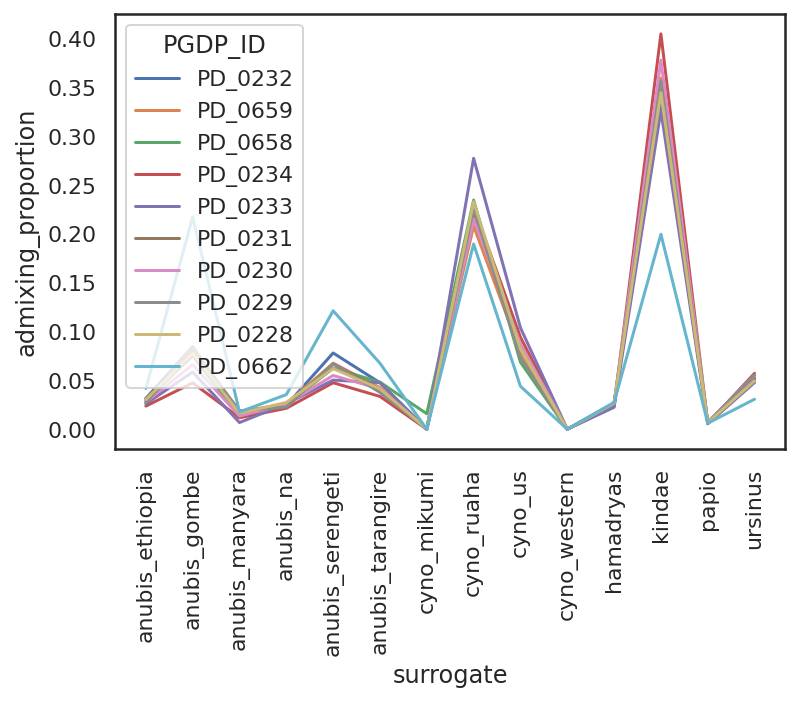

In [10]:
g = sns.lineplot(data=cyno_west.sort_values(by=["surrogate"]), y="admixing_proportion", x="surrogate", hue="PGDP_ID")
plt.xticks(rotation=90)

Visualisation based on whole population

In [11]:
summarized_pop = summarize_pop(df_14_cluster, idfile)

In [12]:
def heatmap_globetrotter(df_one_source):
    col_names = df_one_source.population.unique()
    df = pd.concat([pd.DataFrame([df_one_source.loc[df_one_source.population == population].source.values],
                                 columns = col_names) for population in df_one_source.population.unique()],
                   ignore_index = True)
    df.index = col_names
    df = df.sort_index(axis=0)
    df = df.sort_index(axis=1)
    return df

In [13]:
source1_heatmap = heatmap_globetrotter(summarized_pop.loc[summarized_pop.sourcetype == "source1"])

In [14]:
source2_heatmap = heatmap_globetrotter(summarized_pop.loc[summarized_pop.sourcetype == "source2"])

[Text(0.5, 1.0, 'source1, larger stretches of DNA')]

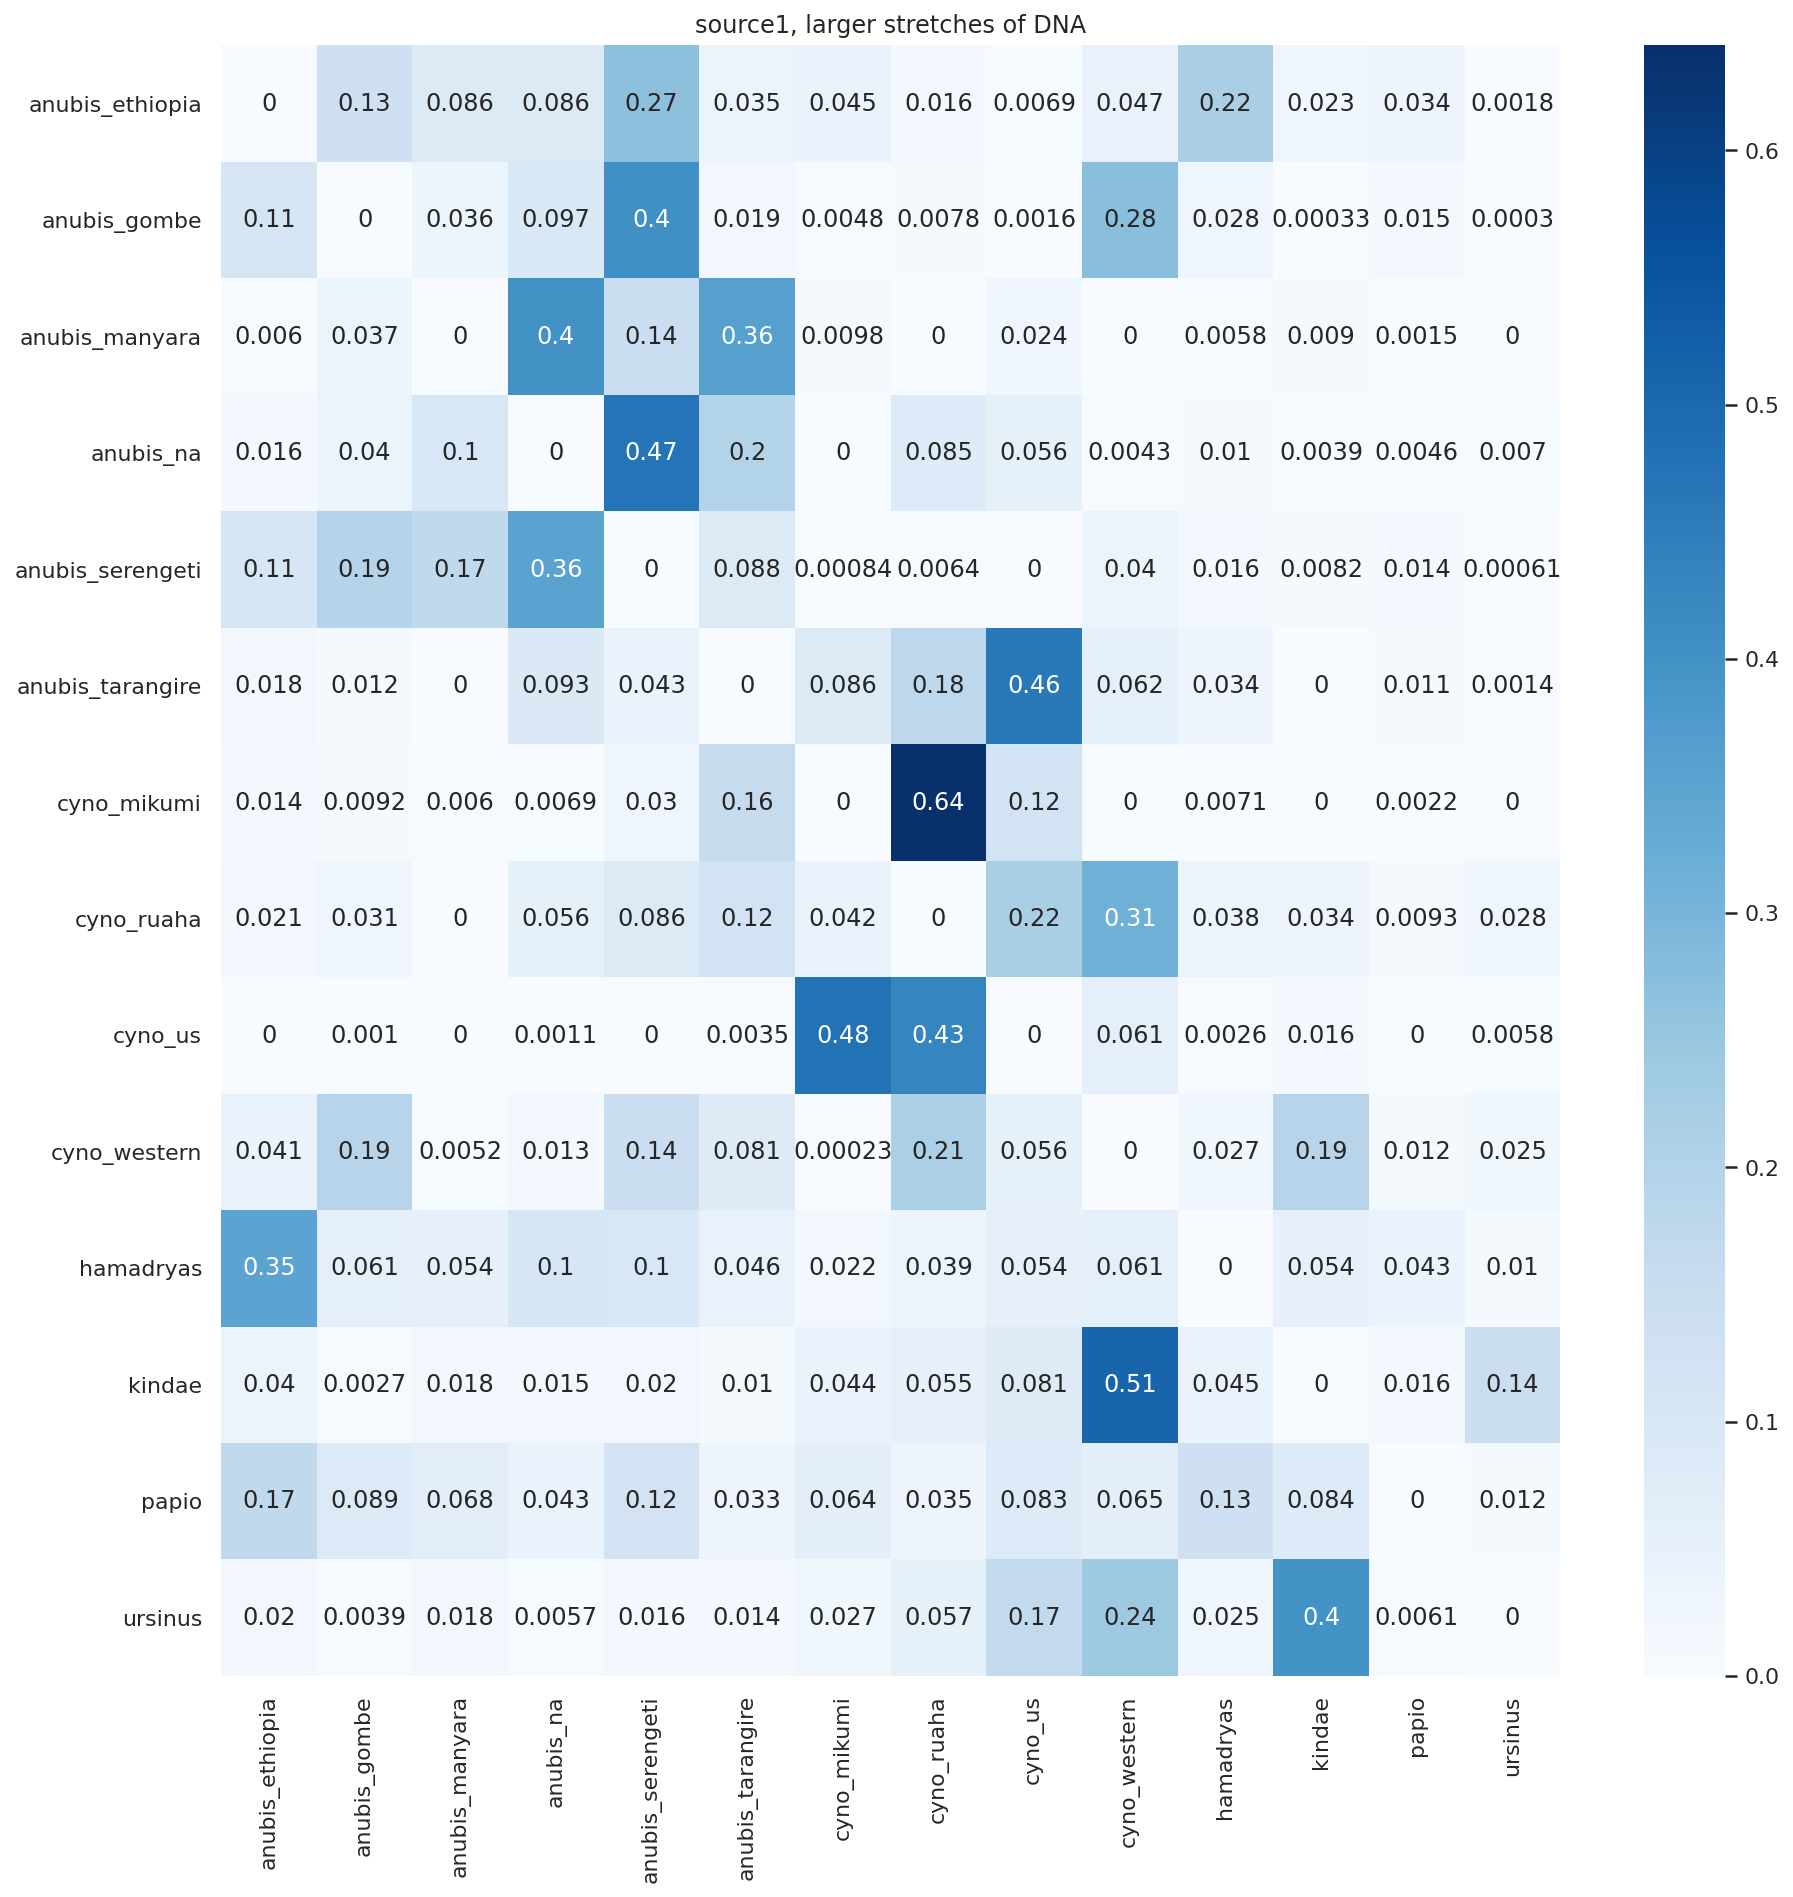

In [15]:
plt.figure(figsize=(15,15))
g = sns.heatmap(source1_heatmap, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt=".2g") # annot=True, fmt=".0g"
g.set(title="source1, larger stretches of DNA")

[Text(0.5, 1.0, 'source2, shorter stretches of DNA')]

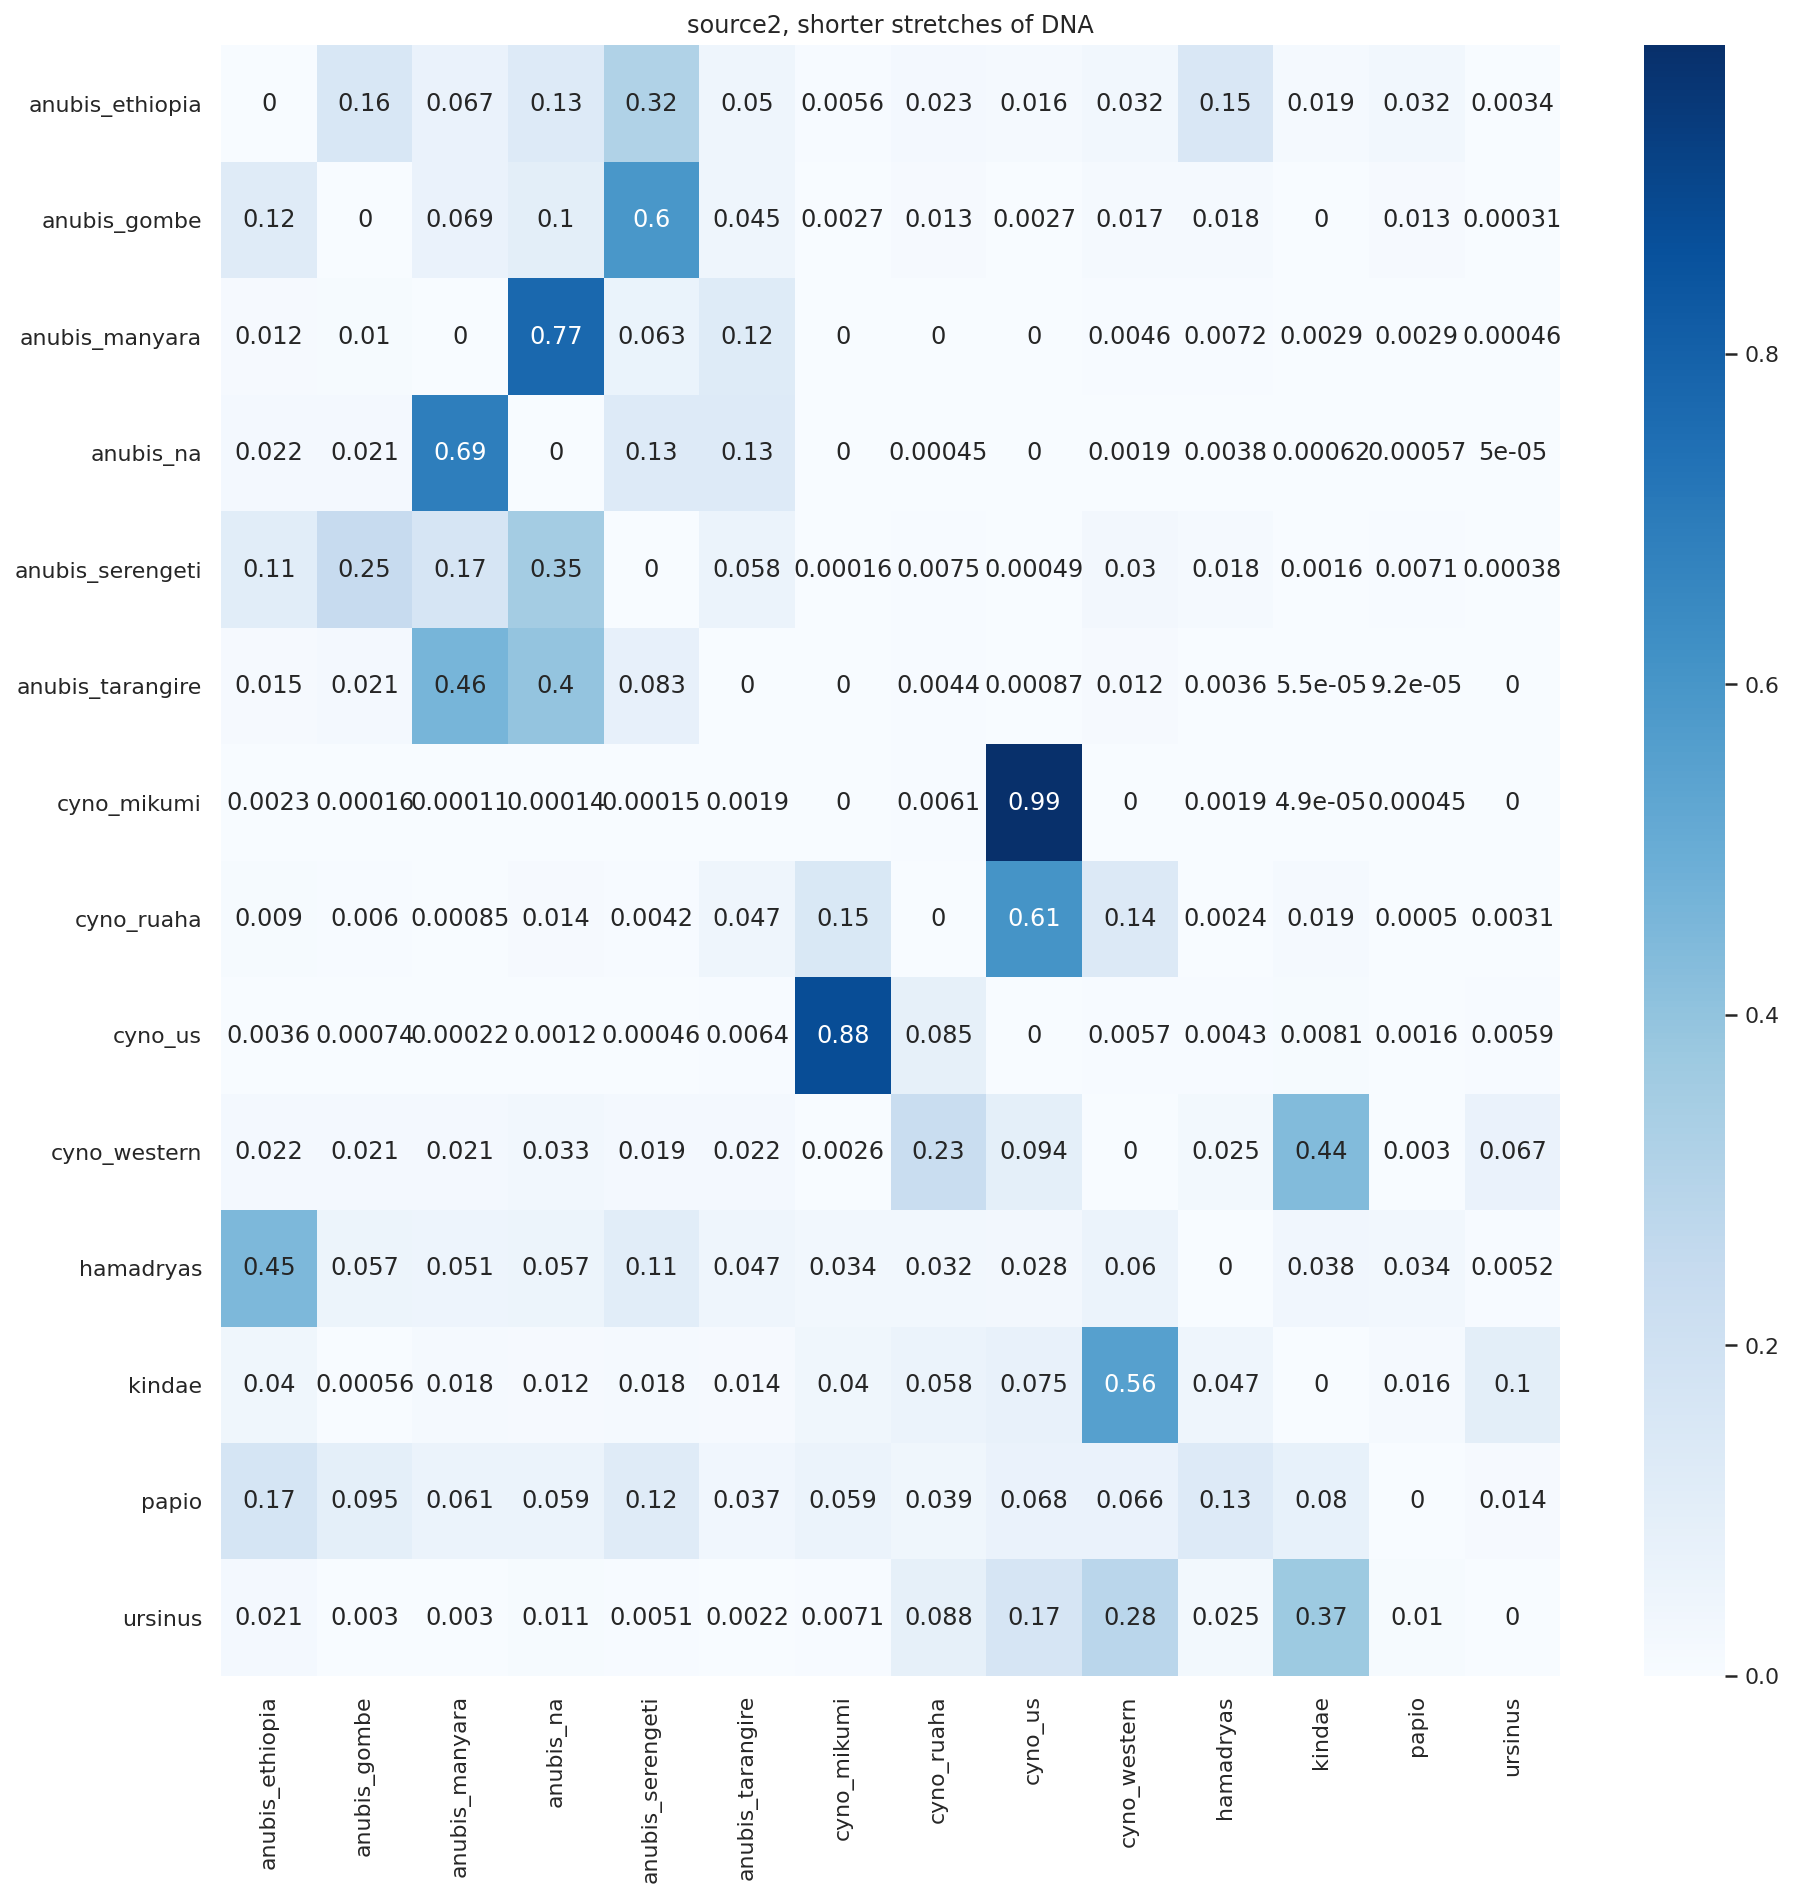

In [16]:
plt.figure(figsize=(15,15))
g = sns.heatmap(source2_heatmap, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt=".2g") # annot=True, fmt=".0g"
g.set(title="source2, shorter stretches of DNA")

[Text(0.5, 1.0, 'source1, shorter stretches of DNA')]

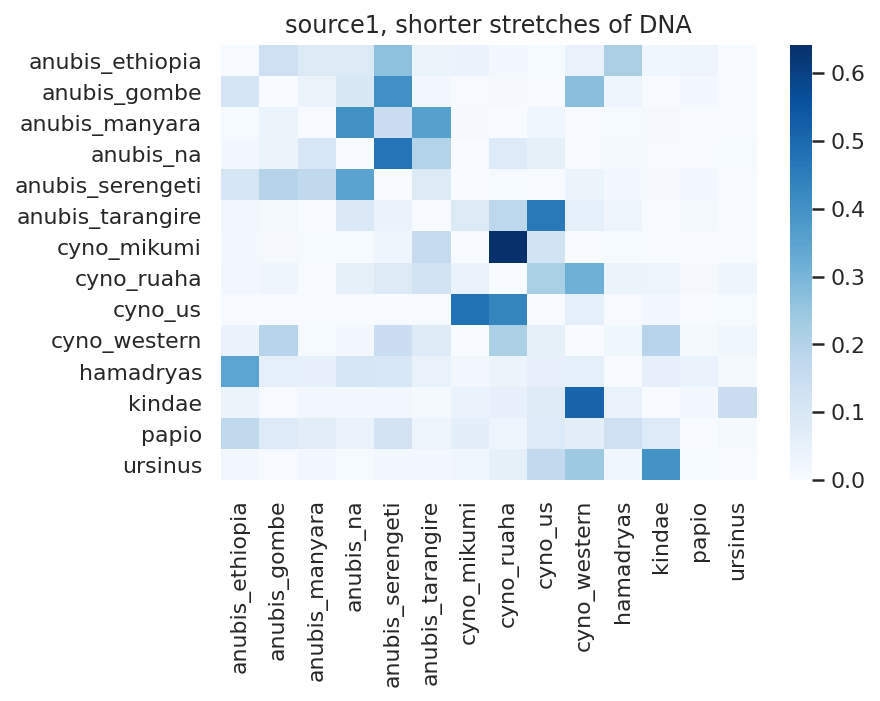

In [17]:
g = sns.heatmap(source1_heatmap, cmap=sns.color_palette("Blues", as_cmap=True))
g.set(title="source1, shorter stretches of DNA")

[Text(0.5, 1.0, 'source2, shorter stretches of DNA')]

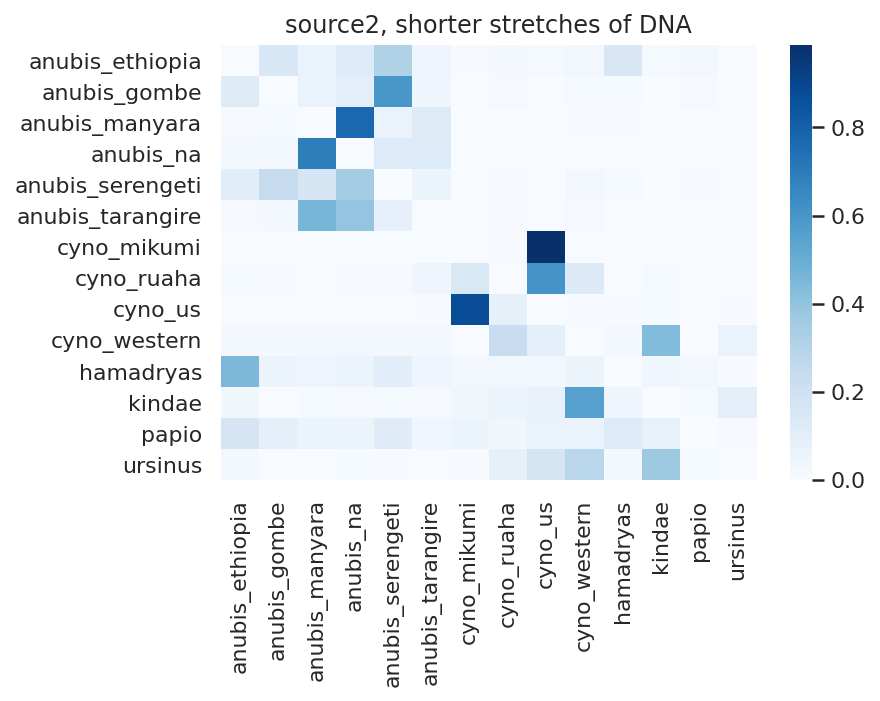

In [18]:
g = sns.heatmap(source2_heatmap, cmap=sns.color_palette("Blues", as_cmap=True))
g.set(title="source2, shorter stretches of DNA")

[Text(0.5, 1.0, 'ratio')]

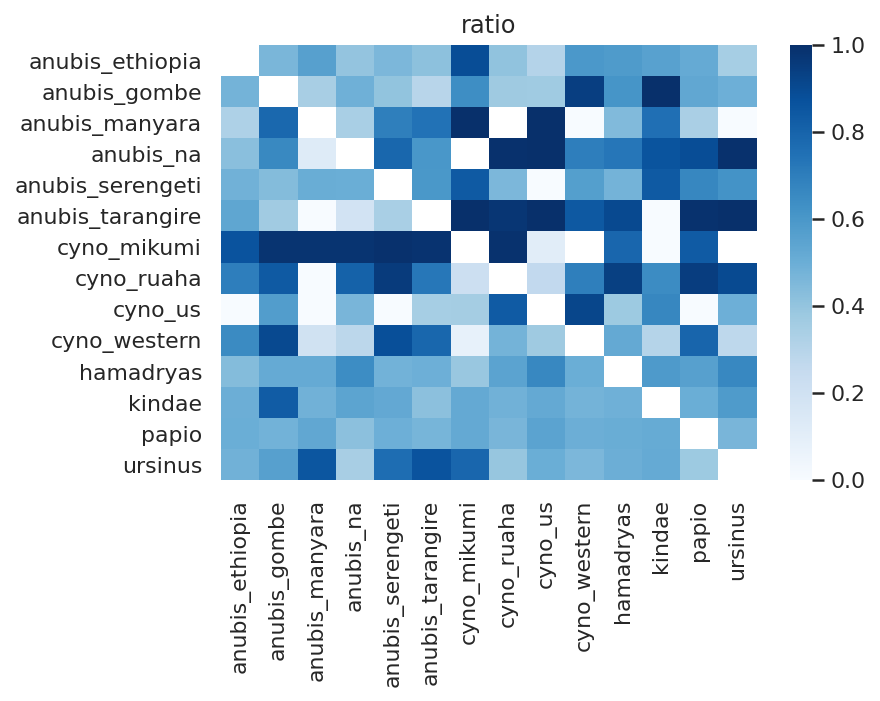

In [19]:
g = sns.heatmap(source1_heatmap/(source2_heatmap+source1_heatmap), cmap=sns.color_palette("Blues", as_cmap=True))
g.set(title="ratio")

In [20]:
source1_heatmap/(source2_heatmap+source1_heatmap)

anubis_ethiopia  anubis_gombe  anubis_manyara  anubis_na  \
anubis_ethiopia               NaN      0.461000        0.561740   0.401734   
anubis_gombe             0.476830           NaN        0.344233   0.490715   
anubis_manyara           0.325797      0.782249             NaN   0.341868   
anubis_na                0.422072      0.660040        0.127284        NaN   
anubis_serengeti         0.487697      0.441290        0.506443   0.501567   
anubis_tarangire         0.536385      0.365728        0.000000   0.189598   
cyno_mikumi              0.864014      0.983364        0.981191   0.980813   
cyno_ruaha               0.699817      0.837142        0.000000   0.804885   
cyno_us                  0.000000      0.578088        0.000000   0.468409   
cyno_western             0.650728      0.902755        0.198631   0.284451   
hamadryas                0.438840      0.517064        0.517622   0.644372   
kindae                   0.498106      0.830195        0.488215   0.546712   
papio                    0.502449      0.482110        0.530380   0.418343   
ursinus                  0.487576      0.560470        0.853184   0.346184   

                  anubis_serengeti  anubis_tarangire  cyno_mikumi  cyno_ruaha  \
anubis_ethiopia           0.459760          0.415119     0.888859    0.409767   
anubis_gombe              0.403733          0.296065     0.639364    0.373751   
anubis_manyara            0.695407          0.743820     1.000000         NaN   
anubis_na                 0.785741          0.604983          NaN    0.994742   
anubis_serengeti               NaN          0.601264     0.839840    0.459681   
anubis_tarangire          0.341741               NaN     1.000000    0.975634   
cyno_mikumi               0.995006          0.987985          NaN    0.990503   
cyno_ruaha                0.953585          0.723715     0.219010         NaN   
cyno_us                   0.000000          0.350104     0.352766    0.834748   
cyno_western              0.881006          0.785676     0.081195    0.478467   
hamadryas                 0.481380          0.494299     0.388980    0.550661   
kindae                    0.524146          0.421659     0.521129    0.485089   
papio                     0.493455          0.470860     0.521220    0.468676   
ursinus                   0.762019          0.864834     0.792132    0.392650   

                   cyno_us  cyno_western  hamadryas    kindae     papio  \
anubis_ethiopia   0.305464      0.597526   0.585563  0.556121  0.517258   
anubis_gombe      0.369719      0.941994   0.610563  1.000000  0.528077   
anubis_manyara    1.000000      0.000000   0.445951  0.755816  0.337091   
anubis_na         1.000000      0.700855   0.728618  0.862663  0.890052   
anubis_serengeti  0.000000      0.568354   0.477301  0.836594  0.666047   
anubis_tarangire  0.998133      0.839893   0.902587  0.000000  0.991994   
cyno_mikumi       0.110280           NaN   0.792004  0.000000  0.833393   
cyno_ruaha        0.264575      0.695476   0.939117  0.645595  0.948292   
cyno_us                NaN      0.914143   0.376343  0.666902  0.000000   
cyno_western      0.371138           NaN   0.520282  0.304078  0.795497   
hamadryas         0.663131      0.502612        NaN  0.587729  0.560105   
kindae            0.519784      0.477823   0.490798       NaN  0.502625   
papio             0.549137      0.499139   0.506559  0.512327       NaN   
ursinus           0.501459      0.459850   0.497798  0.515801  0.377523   

                   ursinus  
anubis_ethiopia   0.349904  
anubis_gombe      0.492453  
anubis_manyara    0.000000  
anubis_na         0.992948  
anubis_serengeti  0.620468  
anubis_tarangire  1.000000  
cyno_mikumi            NaN  
cyno_ruaha        0.901255  
cyno_us           0.493081  
cyno_western      0.275073  
hamadryas         0.660356  
kindae            0.582516  
papio             0.465891  
ursinus                NaN

Mapping, most of the base code taken from Kaspers Maps

In [21]:
# Color map for 14 clusters, as well as imports
mycols = sns.color_palette(["#BEE39C", "#02a802", "#3BAC3B", "#68E068", "#43CB43", "#1F681F", "#FFE7AF",
                            "#FFD062", "#FFDE90", "#FFBD00", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.00784313725490196, 0.6588235294117647, 0.00784313725490196),
 (0.23137254901960785, 0.6745098039215687, 0.23137254901960785),
 (0.40784313725490196, 0.8784313725490196, 0.40784313725490196),
 (0.2627450980392157, 0.796078431372549, 0.2627450980392157),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (1.0, 0.8705882352941177, 0.5647058823529412),
 (1.0, 0.7411764705882353, 0.0),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

In [22]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [23]:
world_midres = gpd.read_file(
    '../software/maps/natural_earth/50m_cultural/ne_50m_admin_0_countries.shp'
)
world_midres.columns
world_midres['continent'] = world_midres.CONTINENT
world_midres['name'] = world_midres.NAME_EN

geodata_dir = Path('../software/maps/baboon_range_data')
ranges_gdf = pd.concat(gpd.read_file(path) for path in geodata_dir.glob('**/*.shp'))

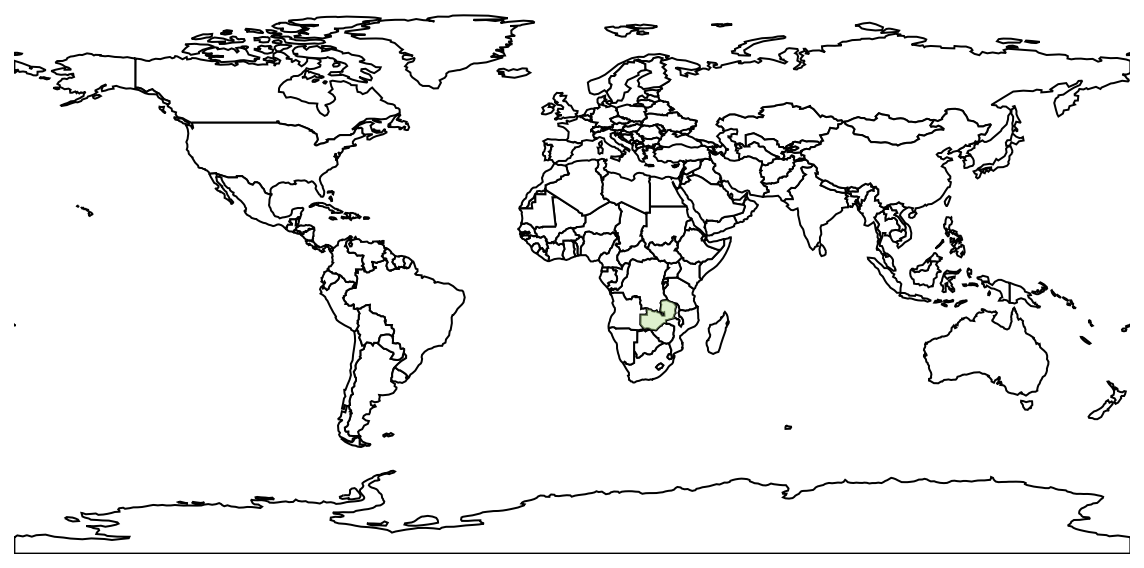

In [24]:
ax = gplt.polyplot(world,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    world.loc[world.name == 'Zambia'], hue='name', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, cmap=mycols_cmap, extent=world.total_bounds.round()
) ;


In [25]:
africa = world[(world.continent == 'Africa') | (world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]
africa_midres = world_midres[(world_midres.continent == 'Africa') | (world_midres.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]

In [26]:
gdf = gpd.GeoDataFrame(meta_data_samples, geometry=gpd.points_from_xy(meta_data_samples.longitude, meta_data_samples.latitude)).loc[lambda df: df.Species != 'gelada']
gdf.loc[gdf.Species == 'ursinus (grayfoot)', 'Species'] = 'ursinus'
gdf.head()

PGDP_ID    Provider_ID                      Provider  Genus       Species  \
0   16066     16066_3130                        Rogers  Papio  cynocephalus   
1   16098     16098_5026                        Rogers  Papio  cynocephalus   
2   30877     30877_3426                    James Else  Papio        anubis   
3   30977     30977_3373                    James Else  Papio        anubis   
4   34449  34449_BZ11022  Rogers/Jolly/Phillips-Conroy  Papio        kindae   

             Origin Sex                                            address  \
0  Mikumi, Tanzania   F   Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania   
1  Mikumi, Tanzania   F   Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania   
2   Aberdare, Kenya   M  Aberdare National Park, Nyeri, Central Kenya, ...   
3   Aberdare, Kenya   F  Aberdare National Park, Nyeri, Central Kenya, ...   
4    Chunga, Zambia   F  Chunga, Mumbwa District, Central Province, Zambia   

   longitude   latitude  callset_index                        C_origin  \
0  36.977032  -7.404852              0  Cynocephalus, Central Tanzania   
1  36.977032  -7.404852              1  Cynocephalus, Central Tanzania   
2  36.712451  -0.410251              2                   Anubis, Kenya   
3  36.712451  -0.410251              3                   Anubis, Kenya   
4  26.005210 -15.053557              4                  Kindae, Zambia   

                     geometry  
0   POINT (36.97703 -7.40485)  
1   POINT (36.97703 -7.40485)  
2   POINT (36.71245 -0.41025)  
3   POINT (36.71245 -0.41025)  
4  POINT (26.00521 -15.05356)

In [27]:
gdf_pop = pd.merge(gdf, idfile, on="PGDP_ID")

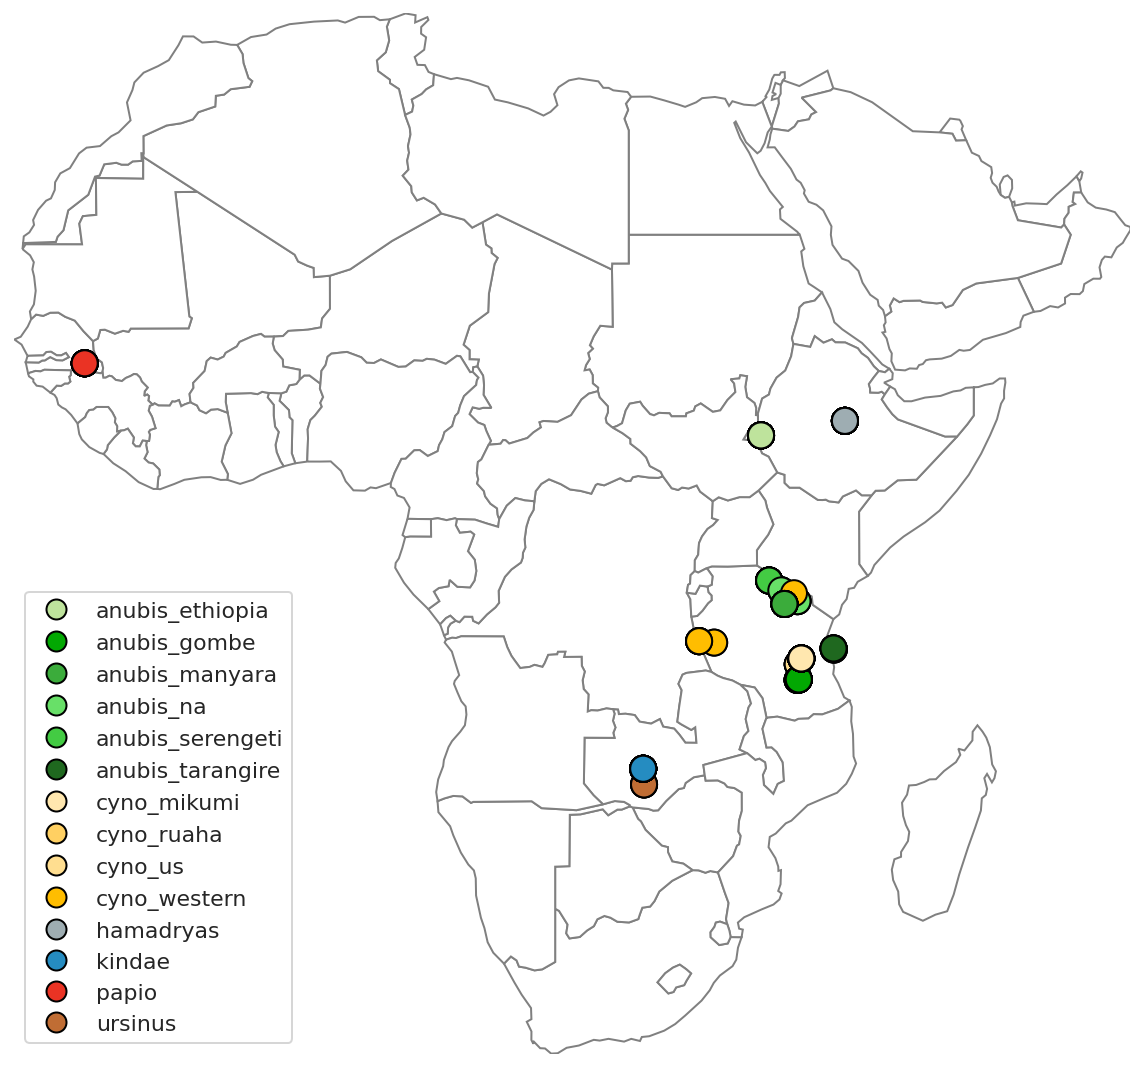

In [28]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='grey', figsize=(10, 12))
ax.set_facecolor('white')

# overwrites first legend
ax = gplt.pointplot(gdf_pop, ax=ax, extent=africa.total_bounds, 
                marker='o', linewidth=1, edgecolor='black',
#               marker='x',
               zorder=10, s=13, hue='population', legend=True, cmap=mycols_cmap, 
              legend_kwargs=dict(loc='lower left'));


Pie chart world

In [29]:
# Function to generate inputs in the Africa map based on a summarized_pop
# Output should be two lists - one with the proportion in the mycol ordering, and one with the degree of explosion.
# Extendend so that only a subset of colors are used.
def pie_input(summarized_one_pop, color_list, cutoff=0):
    s_l1, c_l1, s_l2, c_l2 = [], [], [], []
    df_s2 = summarized_one_pop.loc[summarized_one_pop.sourcetype=="source2"].sort_values(by=["surrogate"]).reset_index()
    for i, row in df_s2.iterrows():
        if row.source > cutoff:
            s_l1.append(row.source*row.proportion), c_l1.append(mycols[i])
    df_s1 = summarized_one_pop.loc[summarized_one_pop.sourcetype=="source1"].sort_values(by=["surrogate"]).reset_index()
    for i, row in df_s1.iterrows():
        if row.source > cutoff:
            s_l2.append(row.source*row.proportion), c_l2.append(mycols[i])
    return s_l1, c_l1, s_l2, c_l2
s_l1, c_l1, s_l2, c_l2 = pie_input(summarized_pop.loc[summarized_pop.population=="anubis_ethiopia"], mycols)

In [30]:
s_l1

[0.1040608084605672,
 0.04428542703470633,
 0.0848877776570366,
 0.2086209836592787,
 0.03300788227955178,
 0.0037132699573089213,
 0.015244877239764944,
 0.010329692702285384,
 0.020870393606016016,
 0.1014881976195152,
 0.012333884785802099,
 0.020897242972051745,
 0.002259562026115205]

I also have to create a location/arrow dict. This sadly has to be quite manual

In [31]:
meta_data_samples.Origin.unique()

array(['Mikumi, Tanzania', 'Aberdare, Kenya', 'Chunga, Zambia', 'captive',
       'Awash, Ethiopia', 'Serengeti, Tanzania', 'Arusha, Tanzania',
       'Ngorongoro, Tanzania', 'Ruaha, Tanzania', 'Gombe, Tanzania',
       'Udzungwa, Tanzania', 'Mahale, Tanzania', 'Katavi, Tanzania',
       'Selous, Tanzania', 'Lake Manyara, Tanzania',
       'Tarangire, Tanzania', 'Niokolo-Koba, Senegal',
       'Issa Valley, Tanzania', 'Dendro Park, Zambia', 'Filoha, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia'], dtype=object)

In [32]:
summarized_pop.sort_values(by="population").population.unique()

array(['anubis_ethiopia', 'anubis_gombe', 'anubis_manyara', 'anubis_na',
       'anubis_serengeti', 'anubis_tarangire', 'cyno_mikumi',
       'cyno_ruaha', 'cyno_us', 'cyno_western', 'hamadryas', 'kindae',
       'papio', 'ursinus'], dtype=object)

In [33]:
arrow_dir = {}
#Order of arguments: x, y, arrow x, arrow y
arrow_dir["anubis_ethiopia"] = [34, 8, -5, 10]
arrow_dir["anubis_gombe"] = [30, -5.5, -20, 8]
arrow_dir["anubis_manyara"] = [36, -4.5, 16, 8]
arrow_dir["anubis_na"] = [35, -3.5, 4, 6]
arrow_dir["anubis_serengeti"] = [34, -2, -14, 10]
arrow_dir["anubis_tarangire"] = [36, -5.5, 24, 0.5]
arrow_dir["cyno_western"] = [31, -7.5, -10, 0]
arrow_dir["cyno_ruaha"] = [34, -8, 0, -10]
arrow_dir["cyno_mikumi"] = [37, -7, 15, -4]
arrow_dir["cyno_us"] = [35, -8, 10, -10]
arrow_dir["hamadryas"] = [40, 9, 10, 5]
arrow_dir["papio"] = [-12.5, 13, 10, 5]
arrow_dir["kindae"] = [25.5, -14.5, -10, -3]
arrow_dir["ursinus"] = [25.5, -16, 0, -10]

In [34]:
#fig, (ax1) = plt.subplots(1)

def pie_chart(source2, colors2, source1=[], colors1=[], radius=1, ax=None):
    
    if ax is None:
        ax = plt.gca()

    #assert abs(1 - sum(source2) - sum(source1)) < 0.001, "sources do not sum to one"
    # Instead of asserting that it should equal 1, I am going to normalize to 1.
    norm_val = 1/(sum(source2)+sum(source1))
    source1 = [x*norm_val for x in source1]
    source2 = [x*norm_val for x in source2]
        
    start_deg = (360 - (360 * sum(source2))) / 2

    patches = []
    colors = []
    offset = radius/4

    patches.append(mpatches.Wedge((0, 0), radius+offset, 0, 360, alpha=0))
    
    for prop in source2:
        patches.append(mpatches.Wedge((0, 0), radius, start_deg, start_deg+360*prop))
        start_deg += 360*prop

    for prop in source1:
        patches.append(mpatches.Wedge((0+offset, 0), radius, start_deg, start_deg+360*prop))
        start_deg += 360*prop

    collection = PatchCollection(patches, edgecolor='black',
                                facecolors=['white']+colors2+colors1,
                                linewidth=1,
                                alpha=[0]+[1]*(len(source1)+len(source2))
                                )
    ax.add_collection(collection)
    ax.axis('equal')
    ax.axis('off')  
    
source2 = [0.2, 0.55]
source1 = [0.10, 0.15]
s_l1, c_l1, s_l2, c_l2 = pie_input(summarized_pop.loc[summarized_pop.population=="anubis_ethiopia"], mycols)
#pie_chart(s_l1, c_l1, s_l2, c_l2, radius=1, ax=ax1)

In [35]:
summarized_pop

source sourcetype  proportion         surrogate       population
0   0.000000    source1    0.062727       cyno_mikumi      cyno_mikumi
1   0.000000    source1    0.062727            kindae      cyno_mikumi
2   0.007121    source1    0.062727         hamadryas      cyno_mikumi
3   0.030368    source1    0.062727  anubis_serengeti      cyno_mikumi
4   0.006913    source1    0.062727         anubis_na      cyno_mikumi
..       ...        ...         ...               ...              ...
9   0.066896    source2    0.662000    anubis_manyara  anubis_ethiopia
10  0.049861    source2    0.662000  anubis_tarangire  anubis_ethiopia
11  0.031567    source2    0.662000             papio  anubis_ethiopia
12  0.003413    source2    0.662000           ursinus  anubis_ethiopia
13  0.000000    source2    0.662000   anubis_ethiopia  anubis_ethiopia

[392 rows x 5 columns]

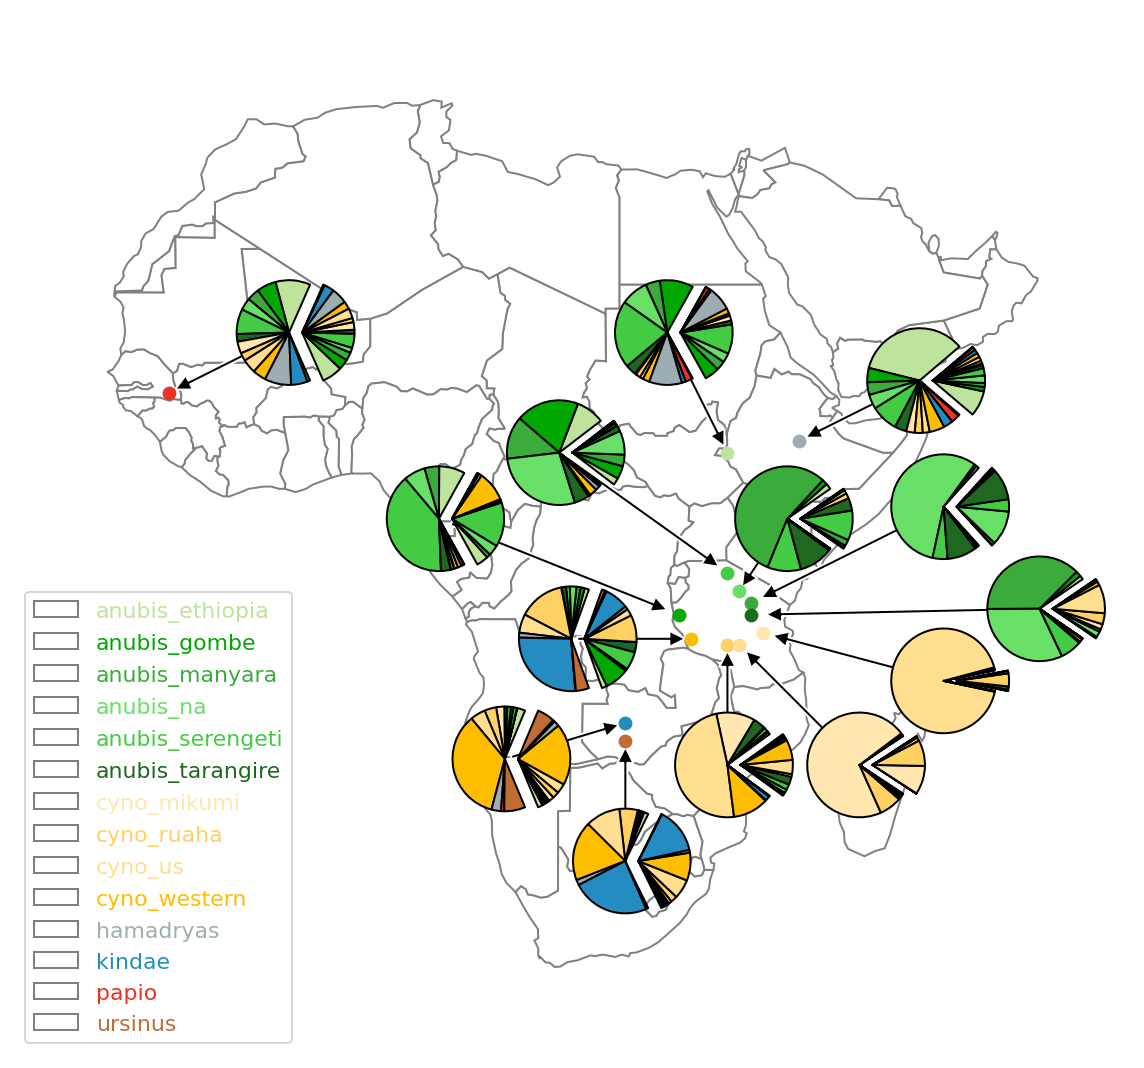

In [36]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))

def plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,ilon,ilat,ax,width,lon_offset=0, lat_offset=0):
    
    if lon_offset or lat_offset:
        ax.scatter(ilon, ilat, color=p_color, zorder=50, s=35)

    ax_sub= inset_axes(ax, width=width, height=width, loc=10, 
                       bbox_to_anchor=(ilon+lon_offset, ilat+lat_offset),
                       bbox_transform=ax.transData, 
                       borderpad=0)

    #print(ax_sub.bbox.x0)
    
    if lon_offset or lat_offset:

        ax.annotate("", xy=(ilon,ilat), xytext=(ilon+lon_offset,ilat+lat_offset), 
                    arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=8, shrink=.05))
    
    #wedges,texts= ax_sub.pie(data, 
    #                         explode=exp_wedge, 
    #                         startangle=0,
    #                         wedgeprops={"edgecolor":"black", 'linewidth': 1},
    #                         normalize=True,
    #                         colors=color_order)
    # Current problem with this implementation: Does not accept hex colors
    pie_chart(s_l1, c_l1, s_l2, c_l2)
    ax_sub.set_aspect("equal")

#plot_pie_inset([0.2, 0.2, 0.45, 0.05], (0.2,0.2,0.2,0.2),mycols,30,10,ax,1, lon_offset=5, lat_offset=10)
i = 0
for population in summarized_pop.sort_values(by="population").population.unique():
    if population in arrow_dir:
        s_l1, c_l1, s_l2, c_l2 = pie_input(summarized_pop.loc[summarized_pop.population==population], mycols)
        x, y, arrow_x, arrow_y = arrow_dir[population]
        p_color = mycols[i]
        plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,x,y,ax,1,lon_offset=arrow_x, lat_offset=arrow_y)
    i += 1
ax.legend(summarized_pop.sort_values(by="population").population.unique(), labelcolor=mycols)

Now basing the dataset on reading the gb.null, as well as allowing for no uncertain admixture.
I am also redefining the functions, as some will be altered a bit

In [37]:
def globetrotter_parse(path, idfile):
    f = open(path)
    lines = f.readlines()
    # Lines 11 to 16 contain the information for PC1, one-date fit.
    df1, df2 = pd.DataFrame(), pd.DataFrame()
    # I am going to implement it in a "long" format
    i = 0
    # This is done so that the most recent event is fitted in the multiple-dates case
    if lines[0].strip().split(" ")[-1][:-1] == "multiple-dates":
        i += 12
    if lines[i].strip().split(" ")
    df1["source"] = lines[12+i].strip().split(" ")[1:]
    df1["sourcetype"] = "source1"
    df1["proportion"] = lines[12+i].split(" ")[0]
    df1["surrogate"] = lines[11+i].strip().split(" ")[1:]
    df2["source"] = lines[14+i].strip().split(" ")[1:]
    df2["sourcetype"] = "source2"
    df2["proportion"] = lines[14+i].split(" ")[0]
    df2["surrogate"] = lines[13+i].strip().split(" ")[1:]
    df = pd.concat([df1, df2])
    df["estimate"] = lines[0].strip().split(" ")[-1][:-1]
    return df

def pie_input(one_pop, color_dir, cutoff=0):
    s_l1, c_l1, s_l2, c_l2 = [], [], [], []
    if one_pop.estimate.unique() == "uncertain" or one_pop.estimate.unique() == "curves/bootstraps":
        for surrogate in one_pop.surrogate.unique():
            sur_rows = one_pop.loc[one_pop.surrogate == surrogate]
            if sum(sur_rows.proportion*sur_rows.source) > cutoff:
                s_l1.append(sum(sur_rows.proportion*sur_rows.source))
                c_l1.append(color_dir[surrogate])
            df = pd.DataFrame({"source": s_l1, "color": c_l1})
            df = df.sort_values(by="source")
        return df.source.to_list(), df.color.to_list(), s_l2, c_l2
    df_s2 = one_pop.loc[one_pop.sourcetype=="source2"]
    for i, row in df_s2.iterrows():
        if row.source > cutoff:
            s_l1.append(row.source*row.proportion), c_l1.append(color_dir[row.surrogate])
    df_s1 = one_pop.loc[one_pop.sourcetype=="source1"]
    for i, row in df_s1.iterrows():
        if row.source > cutoff:
            s_l2.append(row.source*row.proportion), c_l2.append(color_dir[row.surrogate])
    return s_l1, c_l1, s_l2, c_l2

def pie_chart(source2, colors2, source1=[], colors1=[], radius=1, ax=None):
    
    if ax is None:
        ax = plt.gca()

    #assert abs(1 - sum(source2) - sum(source1)) < 0.001, "sources do not sum to one"
    # Instead of asserting that it should equal 1, I am going to normalize to 1.
    norm_val = 1/(sum(source2)+sum(source1))
    source1 = [x*norm_val for x in source1]
    source2 = [x*norm_val for x in source2]
        
    start_deg = (360 - (360 * sum(source2))) / 2

    patches = []
    colors = []
    offset = radius/4

    patches.append(mpatches.Wedge((0, 0), radius+offset, 0, 360, alpha=0))
    
    for prop in source2:
        patches.append(mpatches.Wedge((0, 0), radius, start_deg, start_deg+360*prop))
        start_deg += 360*prop

    for prop in source1:
        patches.append(mpatches.Wedge((0+offset, 0), radius, start_deg, start_deg+360*prop))
        start_deg += 360*prop

    collection = PatchCollection(patches, edgecolor='black',
                                facecolors=['white']+colors2+colors1,
                                linewidth=0.35,
                                alpha=[0]+[1]*(len(source1)+len(source2))
                                )
    ax.add_collection(collection)
    ax.axis('equal')
    ax.axis('off')  
    
def plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,ilon,ilat,ax,width,lon_offset=0, lat_offset=0):
    
    if lon_offset or lat_offset:
        ax.scatter(ilon, ilat, color=p_color, zorder=50, s=35)

    ax_sub= inset_axes(ax, width=width, height=width, loc=10, 
                       bbox_to_anchor=(ilon+lon_offset, ilat+lat_offset),
                       bbox_transform=ax.transData, 
                       borderpad=0)

    #print(ax_sub.bbox.x0)
    
    if lon_offset or lat_offset:

        ax.annotate("", xy=(ilon,ilat), xytext=(ilon+lon_offset,ilat+lat_offset), 
                    arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=8, shrink=.05))
    
    #wedges,texts= ax_sub.pie(data, 
    #                         explode=exp_wedge, 
    #                         startangle=0,
    #                         wedgeprops={"edgecolor":"black", 'linewidth': 1},
    #                         normalize=True,
    #                         colors=color_order)
    # Current problem with this implementation: Does not accept hex colors
    pie_chart(s_l1, c_l1, s_l2, c_l2)
    ax_sub.set_aspect("equal")

Input definitions

In [38]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_14_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

Color definition

In [39]:
mycols = sns.color_palette(["#BEE39C", "#02a802", "#3BAC3B", "#68E068", "#43CB43", "#1F681F", "#FFE7AF",
                            "#FFD062", "#FFDE90", "#FFBD00", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = idfile.loc[idfile.inclusion==1].sort_values(by="population").population.unique()
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.00784313725490196, 0.6588235294117647, 0.00784313725490196),
 (0.23137254901960785, 0.6745098039215687, 0.23137254901960785),
 (0.40784313725490196, 0.8784313725490196, 0.40784313725490196),
 (0.2627450980392157, 0.796078431372549, 0.2627450980392157),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (1.0, 0.8705882352941177, 0.5647058823529412),
 (1.0, 0.7411764705882353, 0.0),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

In [40]:
color_dir

{'anubis_ethiopia': (0.7450980392156863,
  0.8901960784313725,
  0.611764705882353),
 'anubis_gombe': (0.00784313725490196,
  0.6588235294117647,
  0.00784313725490196),
 'anubis_manyara': (0.23137254901960785,
  0.6745098039215687,
  0.23137254901960785),
 'anubis_na': (0.40784313725490196, 0.8784313725490196, 0.40784313725490196),
 'anubis_serengeti': (0.2627450980392157,
  0.796078431372549,
  0.2627450980392157),
 'anubis_tarangire': (0.12156862745098039,
  0.40784313725490196,
  0.12156862745098039),
 'cyno_mikumi': (1.0, 0.9058823529411765, 0.6862745098039216),
 'cyno_ruaha': (1.0, 0.8156862745098039, 0.3843137254901961),
 'cyno_us': (1.0, 0.8705882352941177, 0.5647058823529412),
 'cyno_western': (1.0, 0.7411764705882353, 0.0),
 'hamadryas': (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 'kindae': (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 'papio': (0.9176470588235294, 0.2, 0.1411764705882353),
 'ursinus': (0.7529411764705882, 0.427450980392156

Dir to determine the points, arrows and piechart placement.

In [41]:
arrow_dir = {}
#Order of arguments: x, y, arrow x, arrow y
arrow_dir["anubis_ethiopia"] = [34, 8, -5, 10]
arrow_dir["anubis_gombe"] = [30, -5.5, -20, 8]
arrow_dir["anubis_manyara"] = [36, -4.5, 16, 8]
arrow_dir["anubis_na"] = [35, -3.5, 4, 6]
arrow_dir["anubis_serengeti"] = [34, -2, -14, 10]
arrow_dir["anubis_tarangire"] = [36, -5.5, 24, 0.5]
arrow_dir["cyno_western"] = [31, -7.5, -10, 0]
arrow_dir["cyno_ruaha"] = [34, -8, 0, -10]
arrow_dir["cyno_mikumi"] = [37, -7, 15, -4]
arrow_dir["cyno_us"] = [35, -8, 10, -10]
arrow_dir["hamadryas"] = [40, 9, 10, 5]
arrow_dir["papio"] = [-12.5, 13, 10, 5]
arrow_dir["kindae"] = [25.5, -14.5, -10, -3]
arrow_dir["ursinus"] = [25.5, -16, 0, -10]

arrow_dir["cyno_central"] = [35, -8, 10, -10]
arrow_dir["anubis_tanzania"] = [35, -3.5, 4, 6]

For loop to load files

In [42]:
rundir = "all_autosomes_14_cluster/"
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir+"gb.null.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_14_cluster_null = pd.concat(df_l)

df_14_cluster_null = df_14_cluster_null.astype({"source": float, "proportion": float})

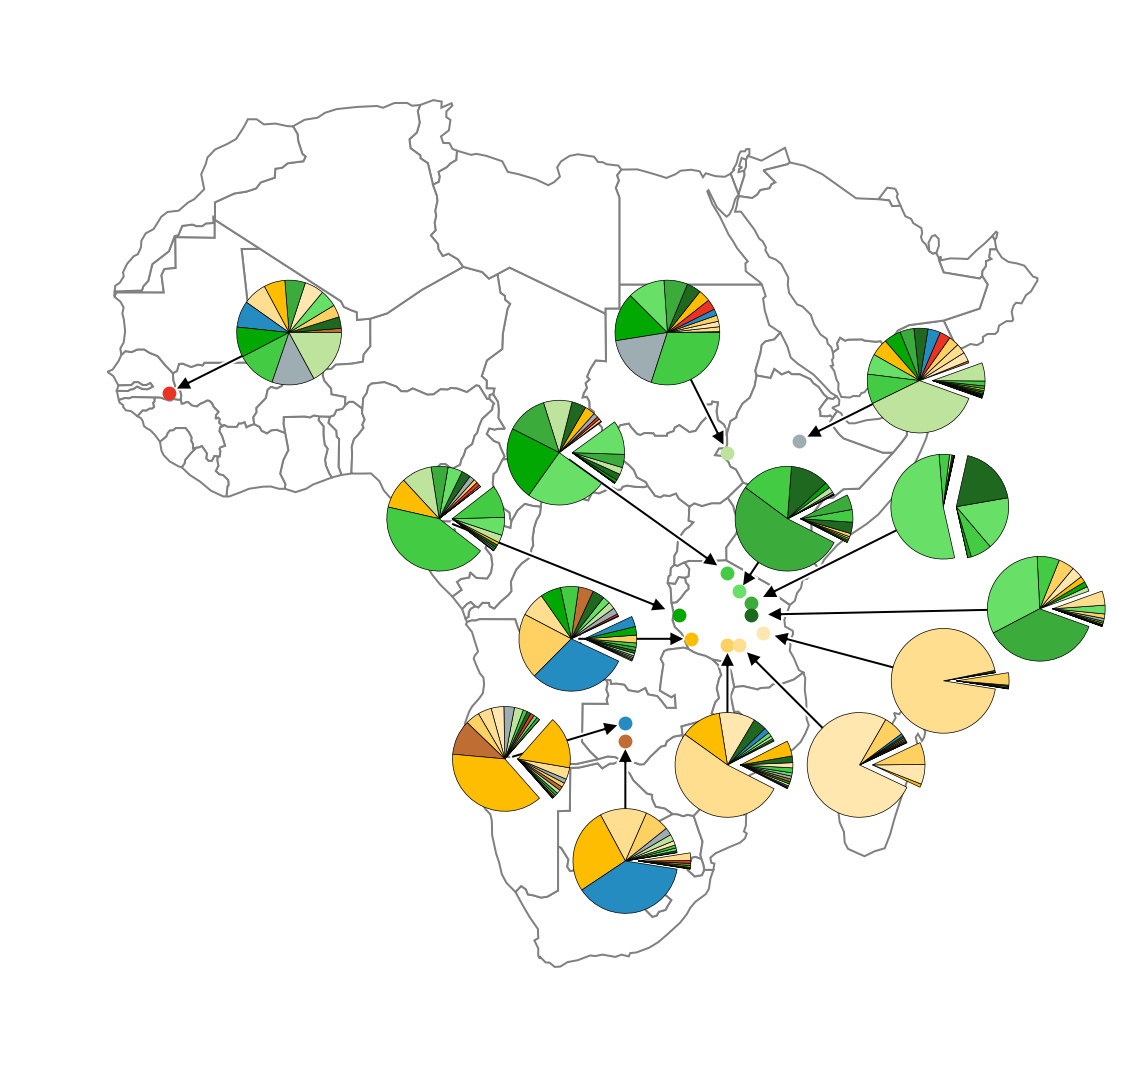

In [43]:
input_df = df_14_cluster_null

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))

for population in input_df.sort_values(by="population").population.unique():
    if population in arrow_dir:
        s_l1, c_l1, s_l2, c_l2 = pie_input(input_df.loc[input_df.population==population],
                                           color_dir, cutoff=0.00)
        x, y, arrow_x, arrow_y = arrow_dir[population]
        p_color = color_dir[population]
        plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,x,y,ax,1,lon_offset=arrow_x, lat_offset=arrow_y)

In [44]:
rundir = "all_autosomes_14_cluster/"
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir+"gb.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_14_cluster = pd.concat(df_l)
df_14_cluster = df_14_cluster.astype({"source": float, "proportion": float})

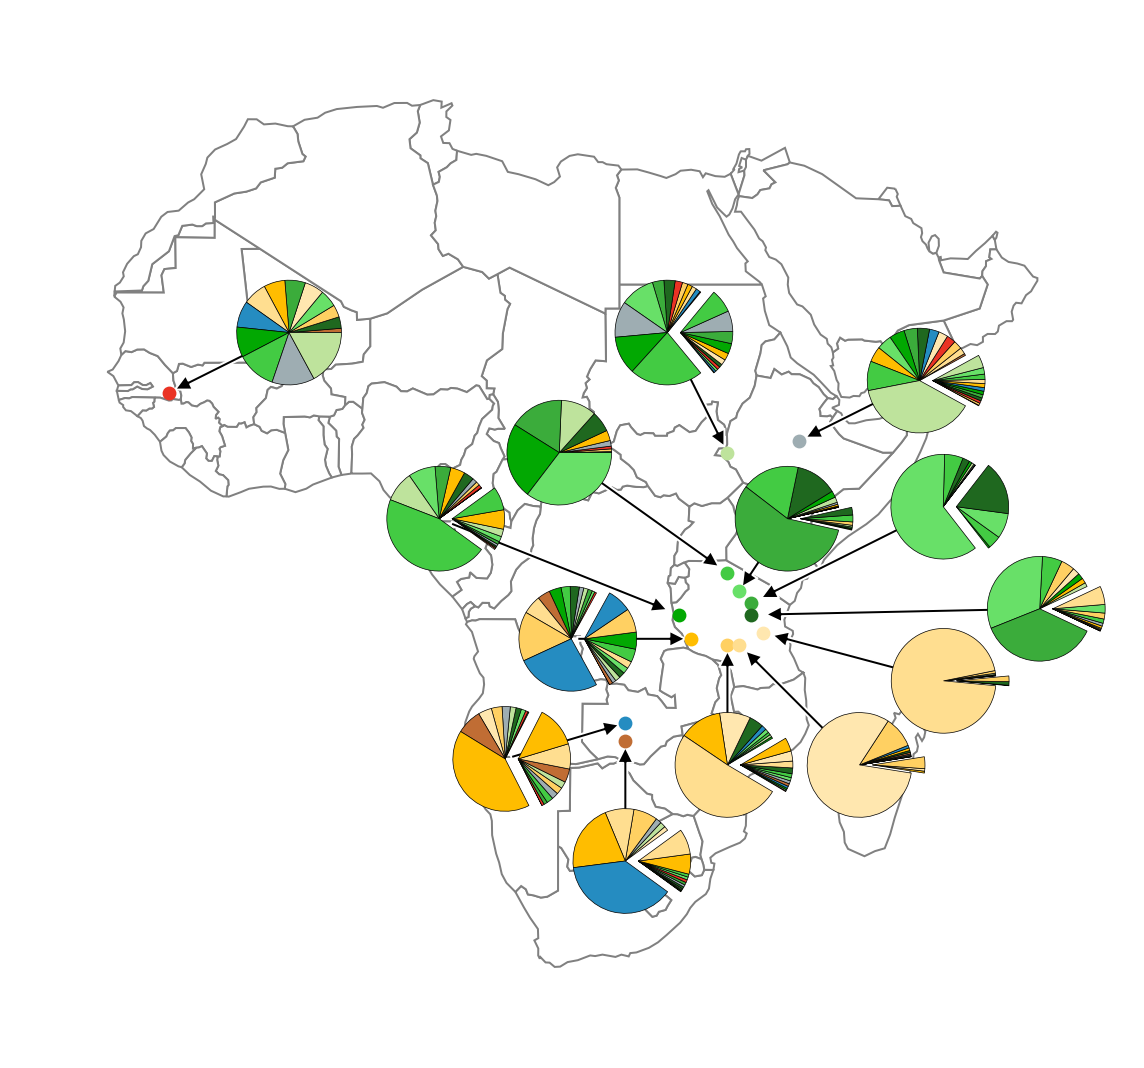

In [45]:
input_df = df_14_cluster

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))

for population in input_df.sort_values(by="population").population.unique():
    if population in arrow_dir:
        s_l1, c_l1, s_l2, c_l2 = pie_input(input_df.loc[input_df.population==population],
                                           color_dir, cutoff=0.00)
        x, y, arrow_x, arrow_y = arrow_dir[population]
        p_color = color_dir[population]
        plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,x,y,ax,1,lon_offset=arrow_x, lat_offset=arrow_y)

In [46]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [47]:
rundir = "all_autosomes_8_cluster/"
color_dir["cyno_central"] = mycols[6]
color_dir["anubis_tanzania"] = mycols[2]
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir+"gb.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_8_cluster = pd.concat(df_l)
df_8_cluster = df_8_cluster.astype({"source": float, "proportion": float})

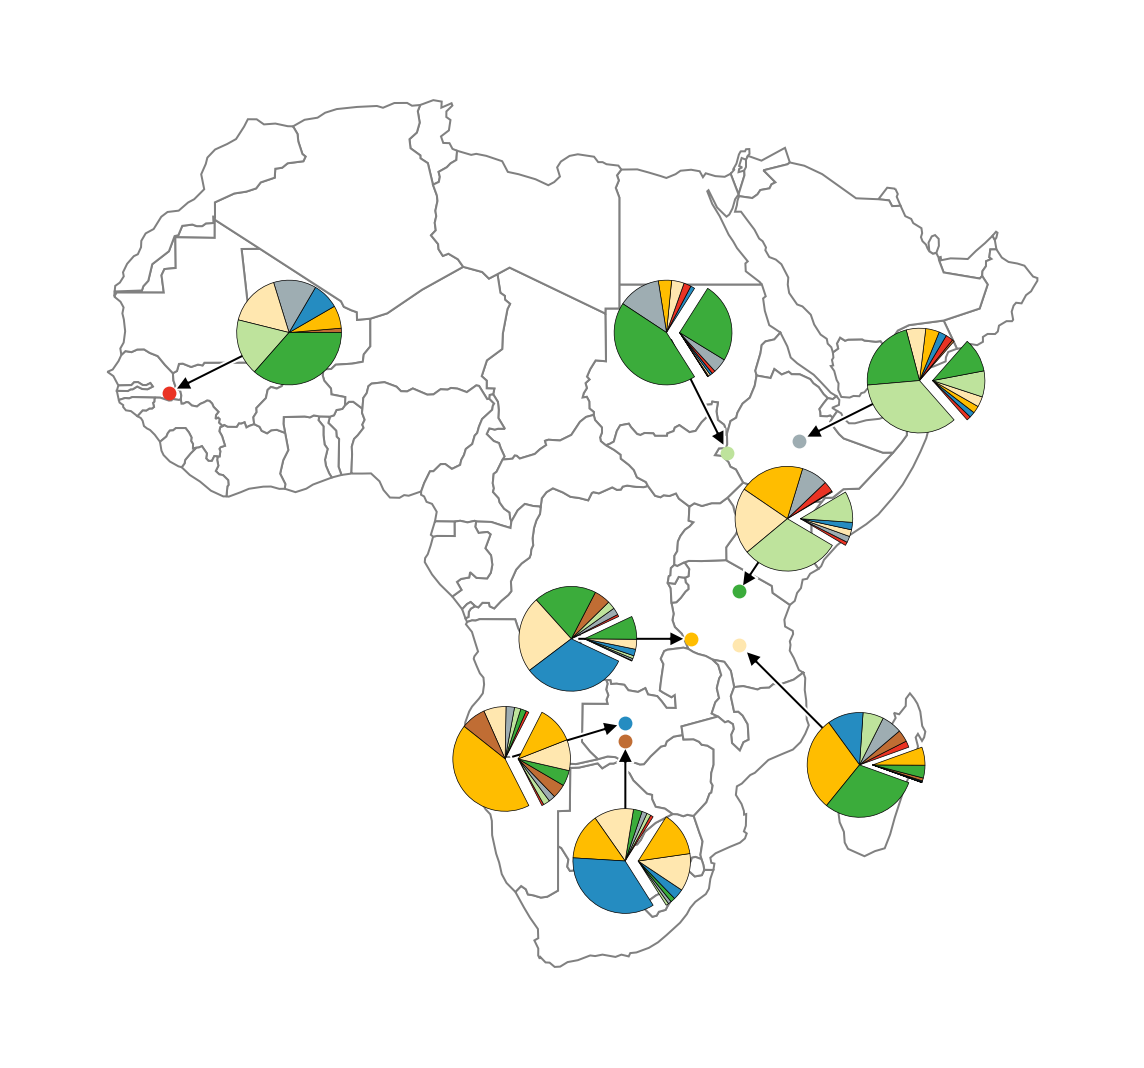

In [48]:
input_df = df_8_cluster

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))

for population in input_df.sort_values(by="population").population.unique():
    if population in arrow_dir:
        s_l1, c_l1, s_l2, c_l2 = pie_input(input_df.loc[input_df.population==population],
                                           color_dir, cutoff=0.00)
        x, y, arrow_x, arrow_y = arrow_dir[population]
        p_color = color_dir[population]
        plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,x,y,ax,1,lon_offset=arrow_x, lat_offset=arrow_y)

In [49]:
rundir = "all_autosomes_8_cluster/"
color_dir["cyno_central"] = mycols[6]
color_dir["anubis_tanzania"] = mycols[2]
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir+"gb.null.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_8_cluster_null = pd.concat(df_l)
df_8_cluster_null = df_8_cluster_null.astype({"source": float, "proportion": float})

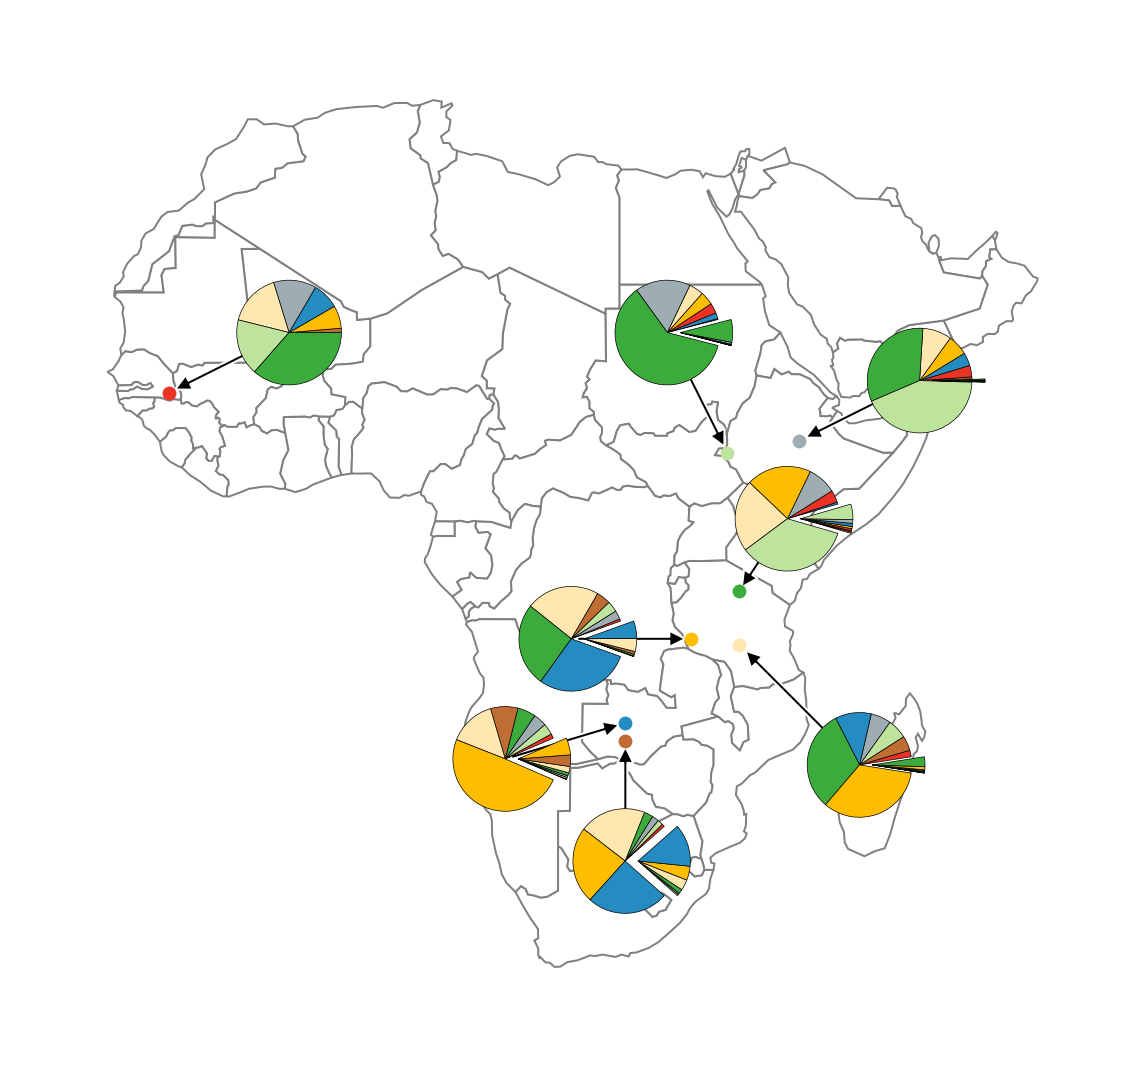

In [50]:
input_df = df_8_cluster_null

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))

for population in input_df.sort_values(by="population").population.unique():
    if population in arrow_dir:
        s_l1, c_l1, s_l2, c_l2 = pie_input(input_df.loc[input_df.population==population],
                                           color_dir, cutoff=0.0)
        x, y, arrow_x, arrow_y = arrow_dir[population]
        p_color = color_dir[population]
        plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,x,y,ax,1,lon_offset=arrow_x, lat_offset=arrow_y)

Also plotting 14 cluster for chr8/chrX

In [51]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [52]:
rundir = "chr8_8_cluster/"
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir+"gb.null.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_8_chr8_null = pd.concat(df_l)
df_8_chr8_null = df_8_chr8_null.astype({"source": float, "proportion": float})

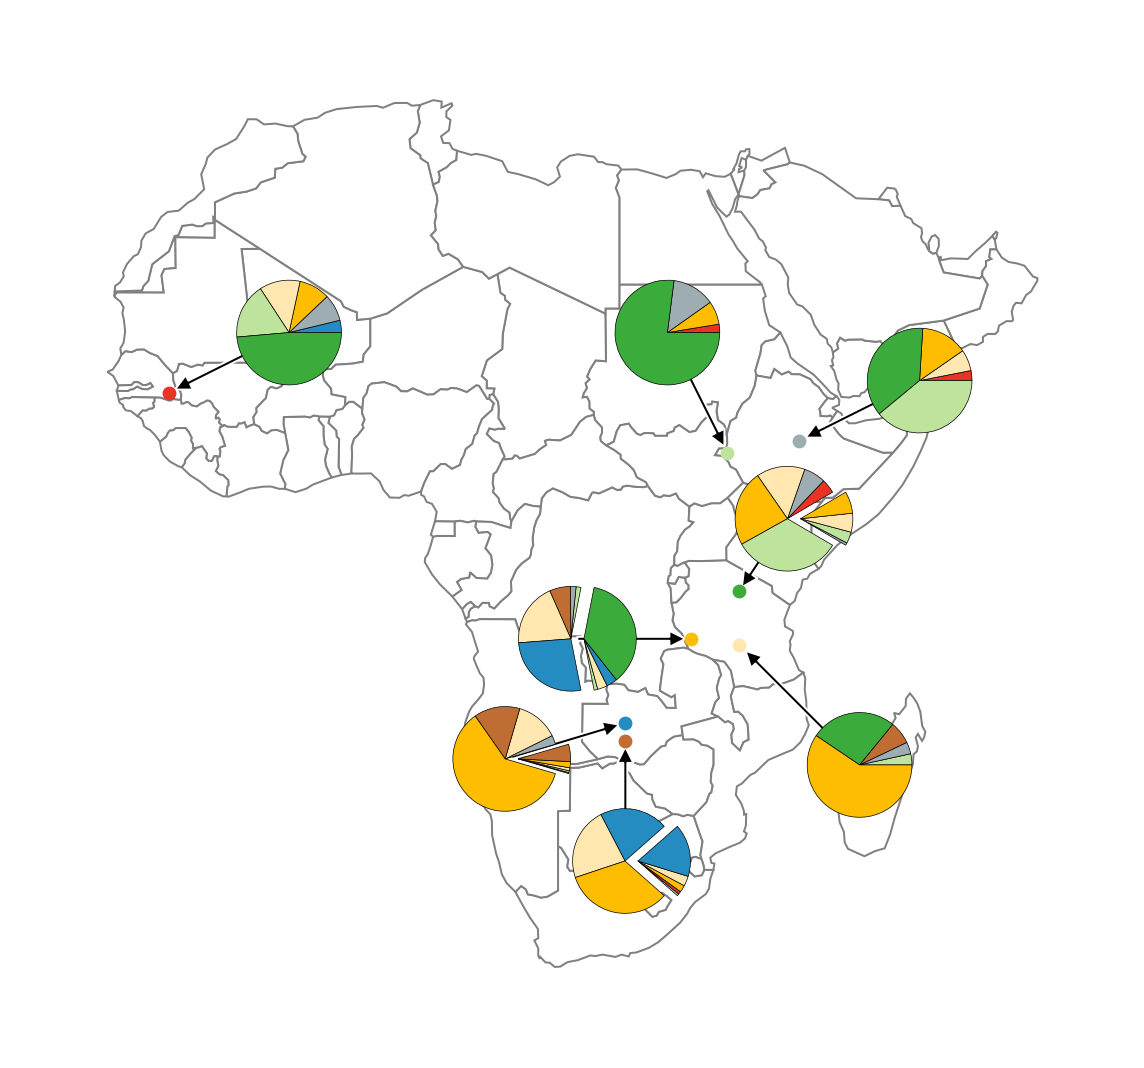

In [53]:
input_df = df_8_chr8_null

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))

for population in input_df.sort_values(by="population").population.unique():
    if population in arrow_dir:
        s_l1, c_l1, s_l2, c_l2 = pie_input(input_df.loc[input_df.population==population],
                                           color_dir, cutoff=0.025)
        x, y, arrow_x, arrow_y = arrow_dir[population]
        p_color = color_dir[population]
        plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,x,y,ax,1,lon_offset=arrow_x, lat_offset=arrow_y)

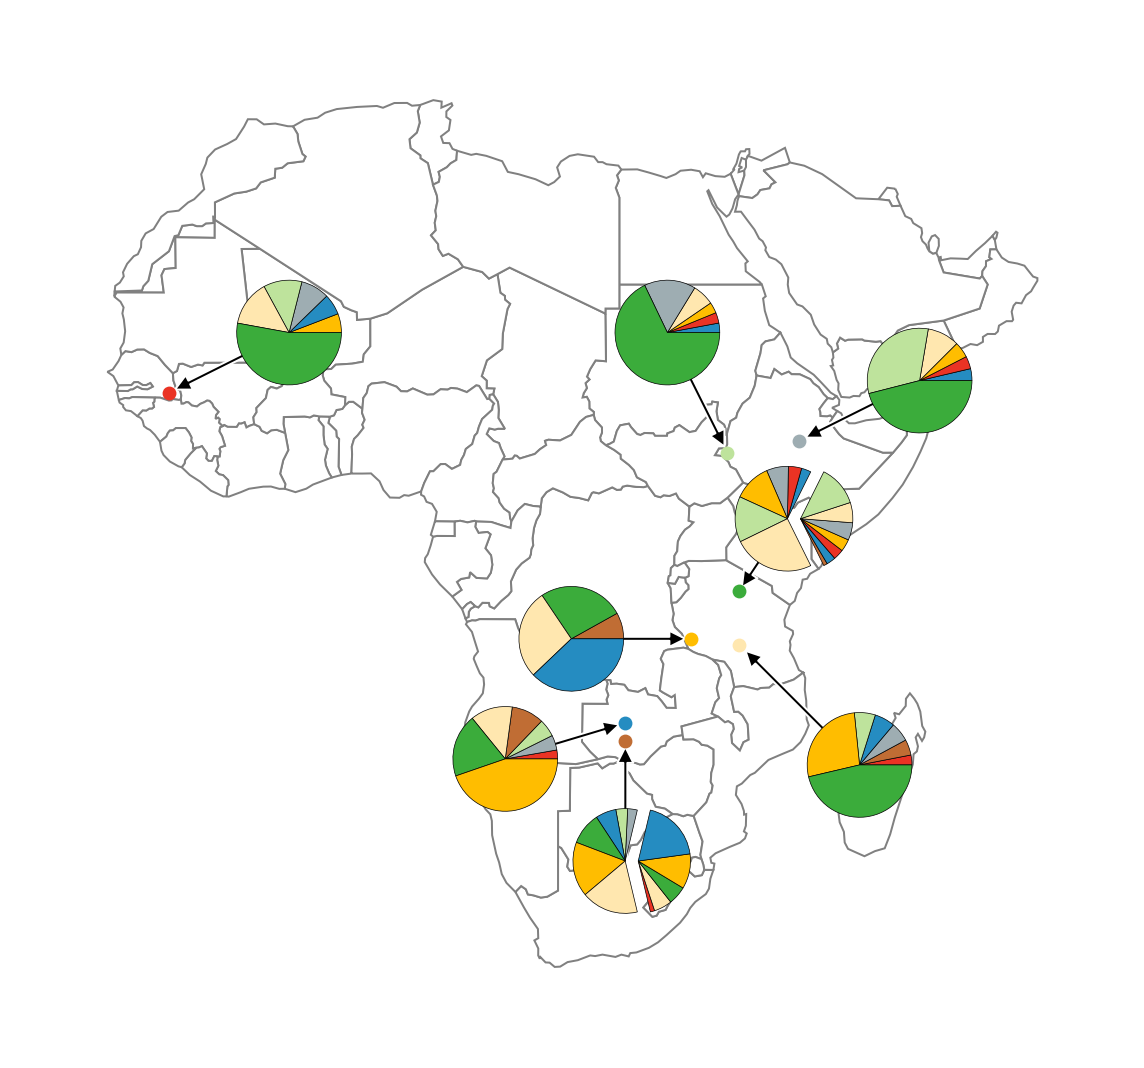

In [54]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

rundir = "chrX_8_cluster/"
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    total_path = step_path+rundir+population+"_"+rundir[:-1]+"_large/gb.null.main.txt"
    df = globetrotter_parse(total_path, idfile)
    df["population"] = population
    df_l.append(df)
df_8_chrX_null = pd.concat(df_l)
df_8_chrX_null = df_8_chrX_null.astype({"source": float, "proportion": float})

input_df = df_8_chrX_null

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))

for population in input_df.sort_values(by="population").population.unique():
    if population in arrow_dir:
        s_l1, c_l1, s_l2, c_l2 = pie_input(input_df.loc[input_df.population==population],
                                           color_dir, cutoff=0.025)
        x, y, arrow_x, arrow_y = arrow_dir[population]
        p_color = color_dir[population]
        plot_pie_inset(s_l1, c_l1, s_l2, c_l2,p_color,x,y,ax,1,lon_offset=arrow_x, lat_offset=arrow_y)

Ancestry component analysis

In [55]:
step_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "population", "inclusion"])
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [56]:
def total_ancestry_parse(path, ID, population, chrom):
    f = open(path)
    lines = f.readlines()
    # Lines 11 to 16 contain the information for PC1, one-date fit.
    df = pd.DataFrame()
    df["surrogate"] = lines[1].strip().split(" ")
    df["proportion"] = lines[2].strip().split(" ")
    df["PGDP_ID"] = ID
    df["population"] = population
    df["chrom"] = chrom
    return df

In [57]:
rundir = "chr8_8_cluster/"
chrom = "chr8"
df_l = []
for population in idfile.loc[idfile.inclusion==1].population.unique():
    for ID in idfile.loc[(idfile.inclusion==1) & (idfile.population == population)].PGDP_ID:
        total_path = step_path+rundir+population+"_"+rundir+"globetrotter_intermediate/"+ID+".main.txt"
        df = total_ancestry_parse(total_path, ID, population, chrom)
        df_l.append(df)

rundir = "chrX_8_cluster_large/"
chrom = "chrX"
for population in idfile.loc[idfile.inclusion==1].population.unique():
    for ID in idfile.loc[(idfile.inclusion==1) & (idfile.population == population)].PGDP_ID:
        total_path = step_path+rundir+population+"_"+rundir+"globetrotter_intermediate/"+ID+".main.txt"
        df = total_ancestry_parse(total_path, ID, population, chrom)
        df_l.append(df)
df_ancestry = pd.concat(df_l)
df_ancestry = df_ancestry.astype({"proportion": float})

In [58]:
#chr8
chrom = "chr8"
l_l = []
i = 0
sort_pop = sorted(idfile.loc[idfile.inclusion==1].population.unique())
for population in sort_pop:
    pop_df = df_ancestry.loc[(df_ancestry.population == population) & (df_ancestry.chrom == chrom)]
    ID_count = len(pop_df.PGDP_ID.unique())
    l_l.append([])
    l_l[i].append(population)
    for surrogate in sort_pop:
        l_l[i].append(sum(pop_df.loc[pop_df.surrogate == surrogate].proportion)/ID_count)
    i += 1
df_8 = pd.DataFrame(columns=["Species"]+sort_pop,
                  data=l_l)
df_8 = df_8.set_index('Species')
df_8.columns.name = "Source populations"
df_8

#chrX
chrom = "chrX"
l_l = []
i = 0
sort_pop = sorted(idfile.loc[idfile.inclusion==1].population.unique())
for population in sort_pop:
    pop_df = df_ancestry.loc[(df_ancestry.population == population) & (df_ancestry.chrom == chrom)]
    ID_count = len(pop_df.PGDP_ID.unique())
    l_l.append([])
    l_l[i].append(population)
    for surrogate in sort_pop:
        l_l[i].append(sum(pop_df.loc[pop_df.surrogate == surrogate].proportion)/ID_count)
    i += 1
df_X = pd.DataFrame(columns=["Species"]+sort_pop,
                  data=l_l)
df_X = df_X.set_index('Species')
df_X.columns.name = "Source populations"
df_X

Source populations  anubis_ethiopia  anubis_tanzania  cyno_central  \
Species                                                              
anubis_ethiopia            0.000000         0.657648      0.081718   
anubis_tanzania            0.253021         0.000000      0.302156   
cyno_central               0.077776         0.487556      0.000000   
cyno_western               0.022666         0.259095      0.264866   
hamadryas                  0.272818         0.463259      0.112588   
kindae                     0.061691         0.236285      0.140138   
papio                      0.117473         0.517286      0.144063   
ursinus                    0.050446         0.200356      0.229899   

Source populations  cyno_western  hamadryas    kindae     papio   ursinus  
Species                                                                    
anubis_ethiopia         0.034709   0.141370  0.034347  0.038097  0.012112  
anubis_tanzania         0.137845   0.119050  0.075631  0.083756  0.028541  
cyno_central            0.208024   0.064590  0.075230  0.037303  0.049136  
cyno_western            0.000000   0.023590  0.349131  0.003351  0.071052  
hamadryas               0.051565   0.000000  0.043557  0.041870  0.014341  
kindae                  0.395361   0.052160  0.000000  0.031970  0.082395  
papio                   0.051570   0.083379  0.064135  0.000000  0.022095  
ursinus                 0.244194   0.039848  0.211565  0.023693  0.000000

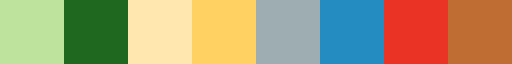

In [59]:
mycols = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = idfile.loc[idfile.inclusion==1].sort_values(by="population").population.unique()
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols_cmap

In [60]:
df_8

Source populations  anubis_ethiopia  anubis_tanzania  cyno_central  \
Species                                                              
anubis_ethiopia            0.000000         0.755849      0.019119   
anubis_tanzania            0.359860         0.000000      0.211341   
cyno_central               0.036659         0.263663      0.000000   
cyno_western               0.026518         0.354992      0.225350   
hamadryas                  0.382143         0.363175      0.064821   
kindae                     0.002828         0.000000      0.136662   
papio                      0.168902         0.479915      0.125158   
ursinus                    0.000000         0.000000      0.251784   

Source populations  cyno_western  hamadryas    kindae     papio   ursinus  
Species                                                                    
anubis_ethiopia         0.067505   0.129908  0.001386  0.025301  0.000000  
anubis_tanzania         0.296618   0.078833  0.003297  0.047942  0.001481  
cyno_central            0.540839   0.038633  0.029491  0.017948  0.071948  
cyno_western            0.000000   0.015682  0.301081  0.000000  0.072191  
hamadryas               0.140215   0.000000  0.011647  0.030806  0.002219  
kindae                  0.615457   0.030387  0.000000  0.016931  0.194625  
papio                   0.088485   0.080926  0.037672  0.000000  0.018943  
ursinus                 0.351805   0.018119  0.362941  0.003474  0.000000

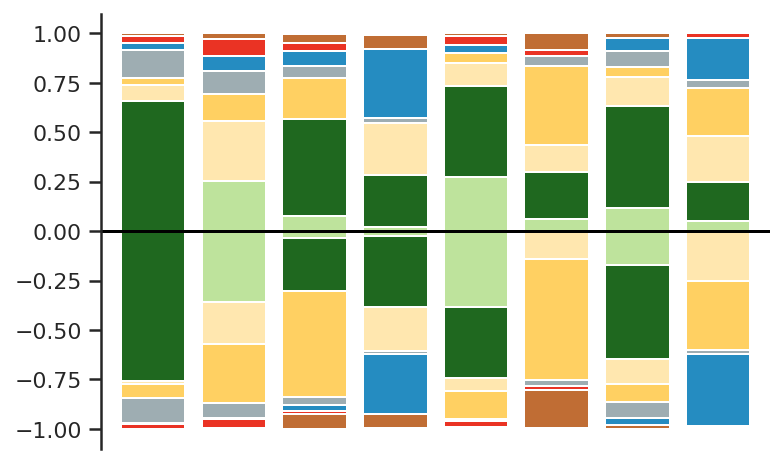

In [61]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots()
    df_X.plot(kind='bar', stacked=True,  ax=ax, width=0.8, legend=False, cmap=mycols_cmap)
    (-1*df_8).plot(kind='bar', stacked=True,  ax=ax, width=0.8, legend=False, cmap=mycols_cmap)# Color map can be your population colormap
    plt.axhline(0, color='black')
    sns.despine()
    #ax.legend(bbox_to_anchor=(1, 1.02))
    ax.axes.get_xaxis().set_visible(False)
    ax.spines['bottom'].set_visible(False)

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/categorical.py:2802: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='proportion', ylabel='surrogate'>

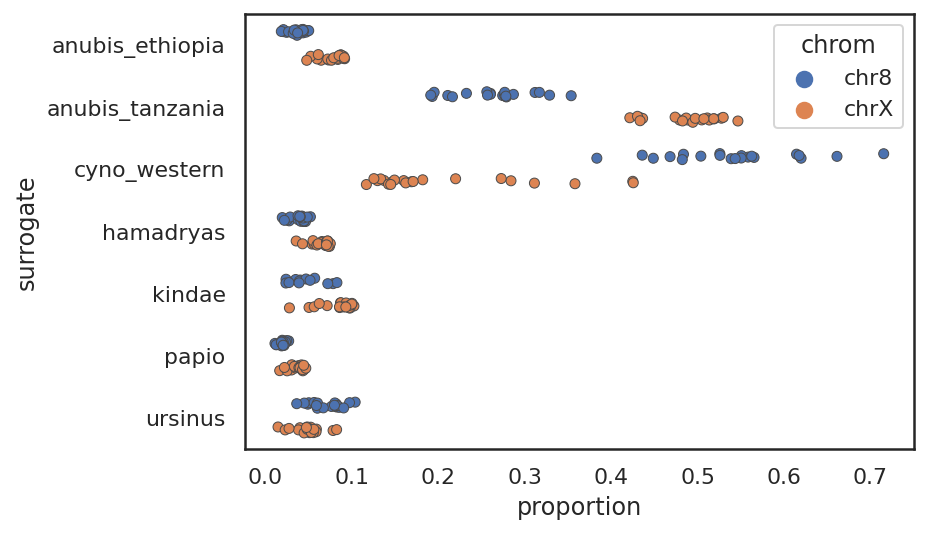

In [62]:
sns.stripplot(data=df_ancestry.loc[(df_ancestry.population=="cyno_central")].sort_values(by=["surrogate", "chrom"]), x="proportion", y="surrogate",
              hue="chrom", split=True, linewidth=0.5)

In [63]:
cyno_mikumi = df_ancestry.loc[df_ancestry.PGDP_ID.isin(meta_data_samples.loc[meta_data_samples.Origin == "Mikumi, Tanzania"].PGDP_ID)]

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/categorical.py:2802: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='proportion', ylabel='surrogate'>

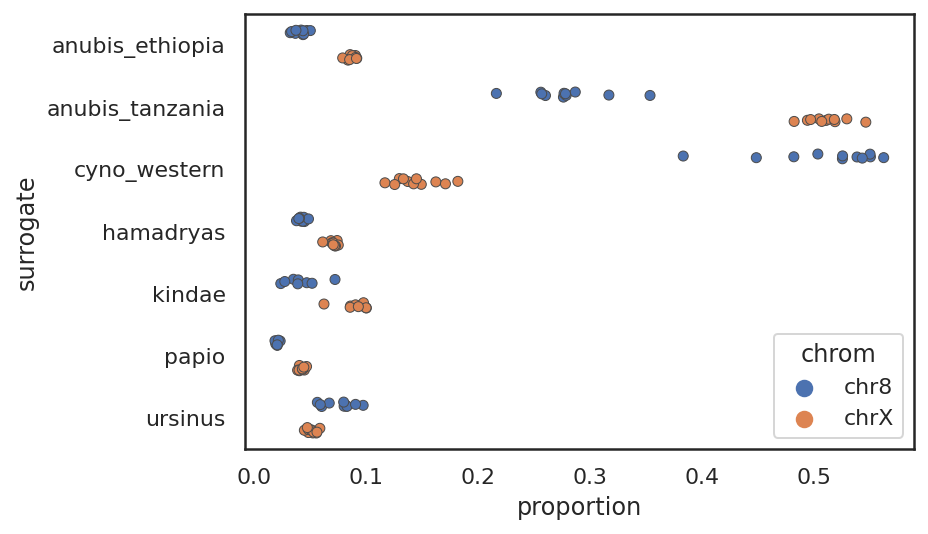

In [64]:
sns.stripplot(data=cyno_mikumi.sort_values(by=["surrogate", "chrom"]), x="proportion", y="surrogate",
              hue="chrom", split=True, linewidth=0.5)

<AxesSubplot:xlabel='proportion', ylabel='surrogate'>

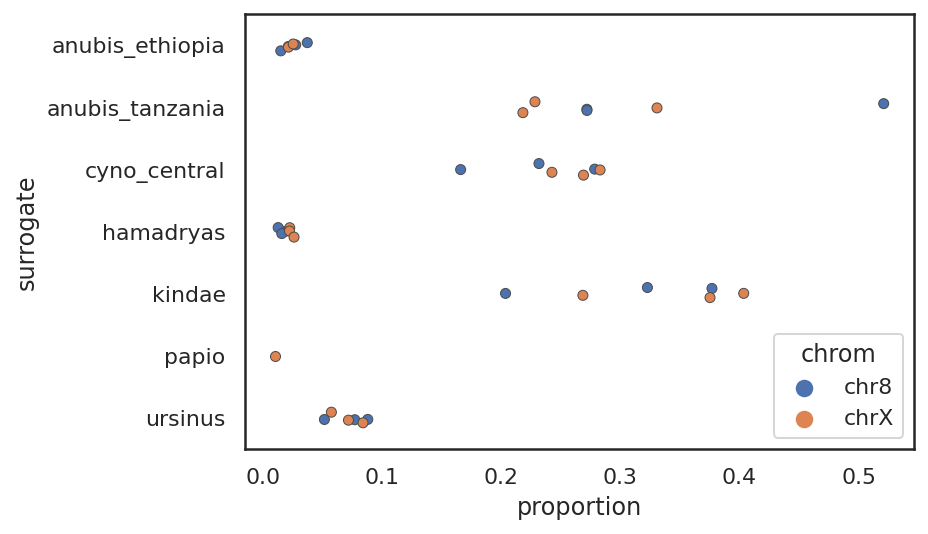

In [65]:
sns.stripplot(data=df_ancestry.loc[df_ancestry.population=="cyno_western"].sort_values(by=["surrogate", "chrom"]), x="proportion", y="surrogate", hue="chrom", linewidth=0.5)

<AxesSubplot:xlabel='proportion', ylabel='surrogate'>

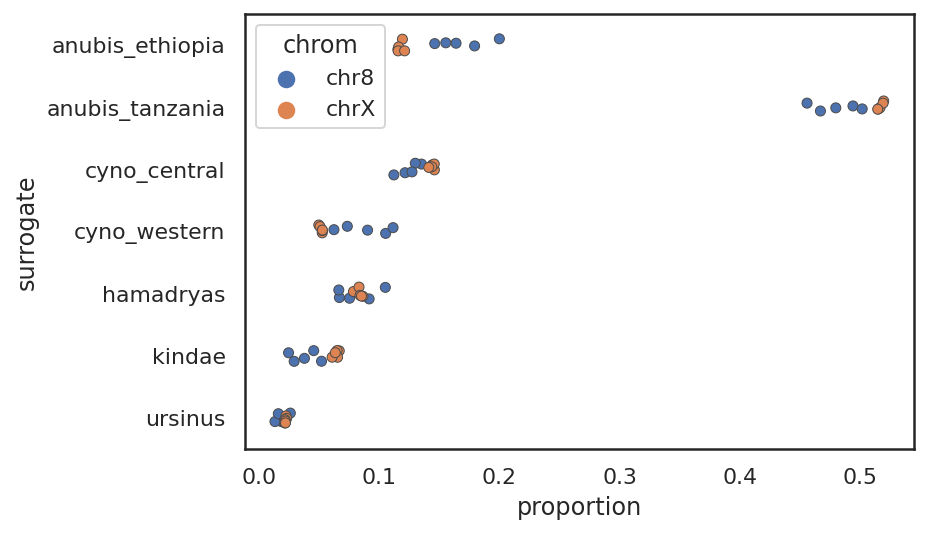

In [66]:
sns.stripplot(data=df_ancestry.loc[df_ancestry.population=="papio"].sort_values(by=["surrogate", "chrom"]), x="proportion", y="surrogate", hue="chrom", linewidth=0.5)

<AxesSubplot:xlabel='proportion', ylabel='surrogate'>

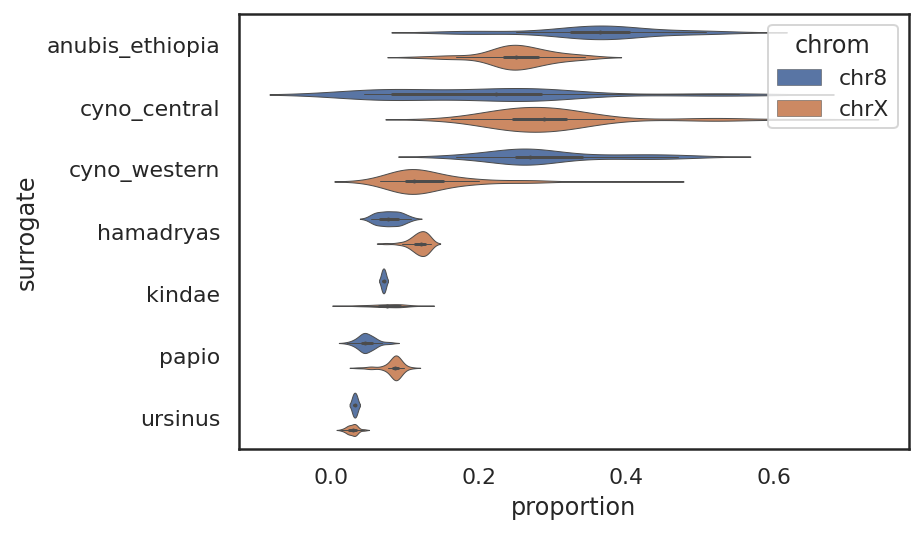

In [67]:
sns.violinplot(data=df_ancestry.loc[df_ancestry.population=="anubis_tanzania"].sort_values(by=["surrogate", "chrom"]), x="proportion", y="surrogate", hue="chrom", linewidth=0.5)